In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ustawienia wykresów
sns.set(style="whitegrid")
%matplotlib inline


In [7]:
# wczytanie zbioru treningowego
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

# szybki podgląd danych
train.head()
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [8]:
# brakujące wartości
missing = train.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

# podział zmiennych na kategoryczne i numeryczne
num_vars = train.select_dtypes(include=np.number).columns.tolist()
cat_vars = train.select_dtypes(include='object').columns.tolist()

In [25]:
# korelacja zmiennych numerycznych do SalePrice
corr = train[num_vars].corr()
corr_target = corr['SalePrice'].sort_values(ascending=False)
print(corr_target.head(11)) # 10 zmiennych numerycznych o najśliniejszej zależności

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


In [29]:
# srednia cena dla zmiennych kategorycnych
def cat_effect_size(df, col, min_count=10, max_unique=30):
    """
    Zwraca miarę 'efektu' kolumny kategorycznej na SalePrice:
    wagowe odchylenie standardowe średnich grupowych (wyższe = większy efekt).
    Pomija kategorie z bardzo małą liczebnością (min_count).
    Pomija kolumny z zbyt wieloma unikatami (max_unique).
    """
    counts = df[col].value_counts(dropna=False)
    if counts.shape[0] > max_unique:
        return np.nan  
        
    valid = counts[counts >= min_count].index
    if len(valid) < 2:
        return np.nan
        
    grp = df[df[col].isin(valid)].groupby(col)['SalePrice'].agg(['mean','count'])
    overall_mean = df.loc[df[col].isin(valid),'SalePrice'].mean()
    
    # wagowe odchylenie avgów 
    weights = grp['count'] / grp['count'].sum()
    weighted_mean_means = (weights * grp['mean']).sum()
    var_between = (weights * (grp['mean'] - weighted_mean_means)**2).sum()
    effect = np.sqrt(var_between)  # im wyższe, tym większy "efekt"
    return effect

cat_effects = {}
for c in cat_vars:
    eff = cat_effect_size(train, c, min_count=20, max_unique=30)  # dostosuj min_count jeśli potrzeba
    if not np.isnan(eff):
        cat_effects[c] = eff

# posortowanie malejąco i wypisanie top10
top10_cat = pd.Series(cat_effects).sort_values(ascending=False).head(10)
print("Top10 zmiennych kategorycznych wg efektu (std średnich ważonych):")
print(top10_cat)

Top10 zmiennych kategorycznych wg efektu (std średnich ważonych):
Neighborhood    58526.621208
ExterQual       54364.518428
KitchenQual     53662.566028
BsmtQual        53457.770612
GarageFinish    40839.569417
Foundation      40322.637867
GarageType      35621.758141
HeatingQC       35039.622167
BsmtFinType1    34827.720560
Exterior1st     30499.618939
dtype: float64


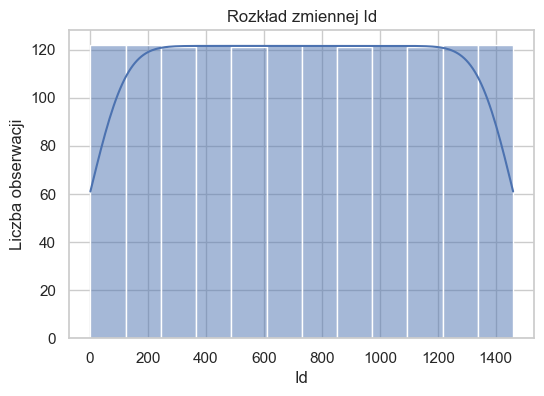

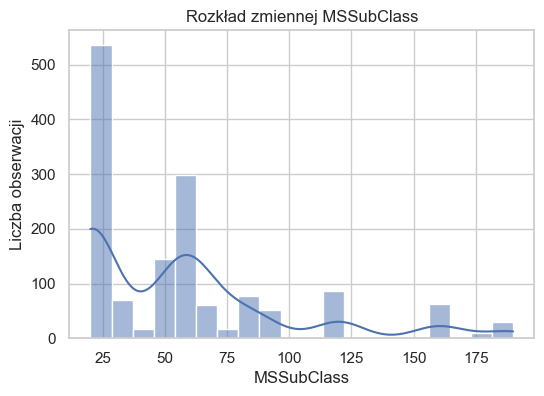

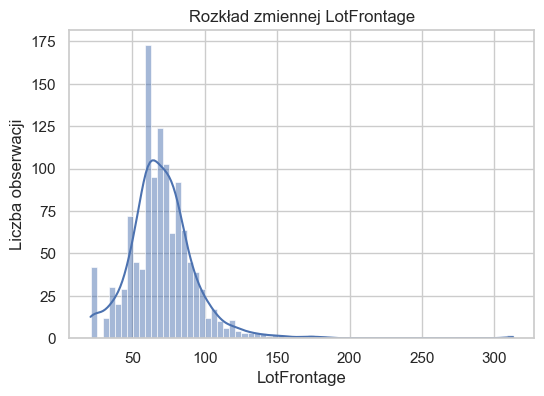

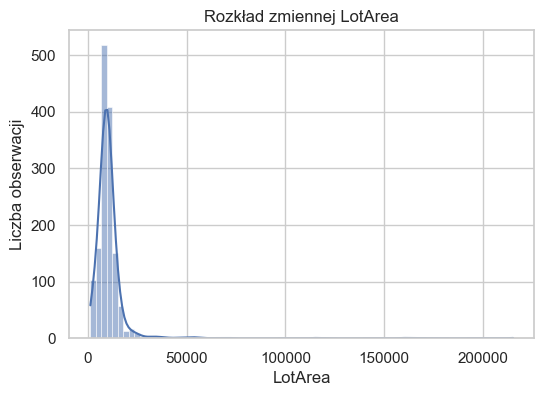

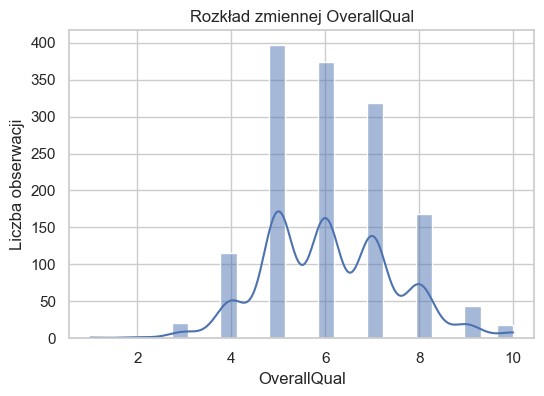

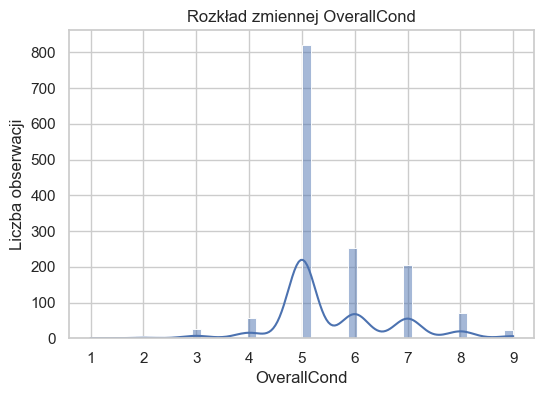

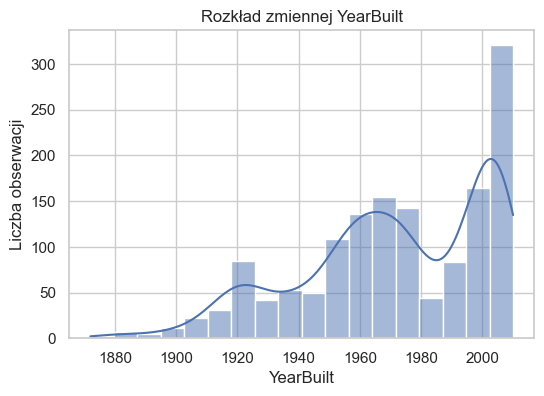

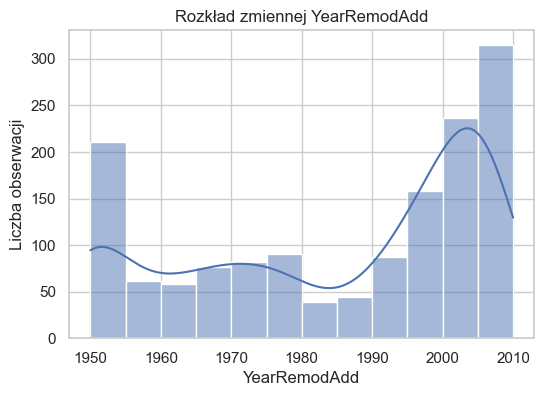

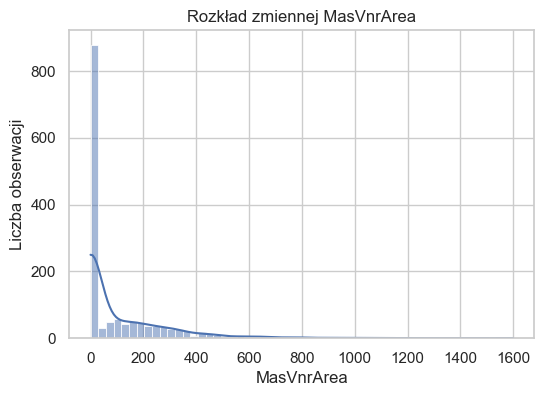

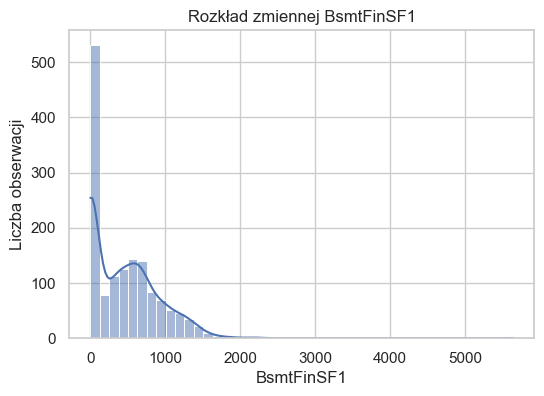

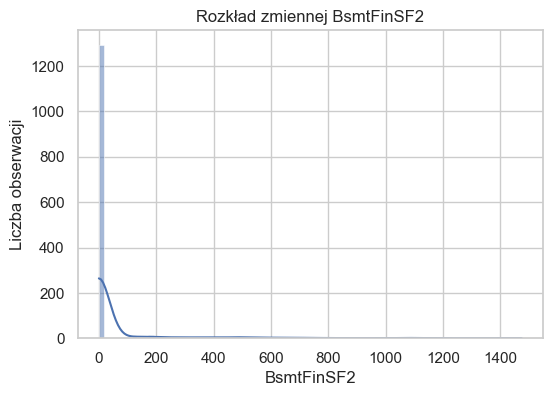

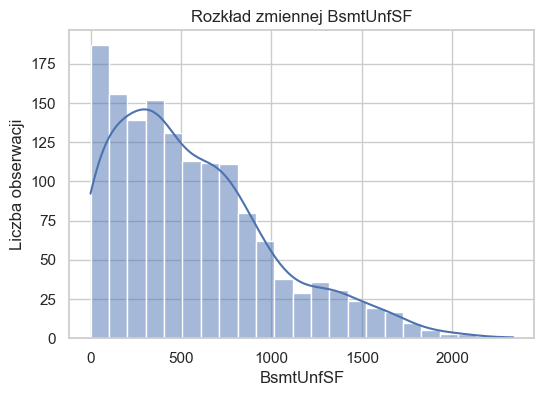

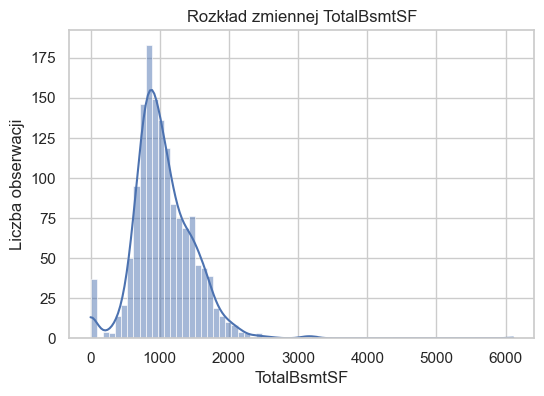

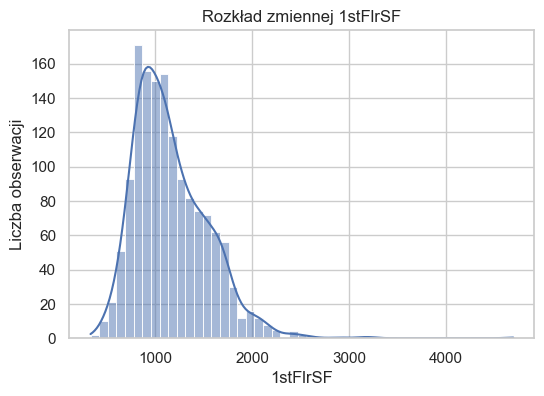

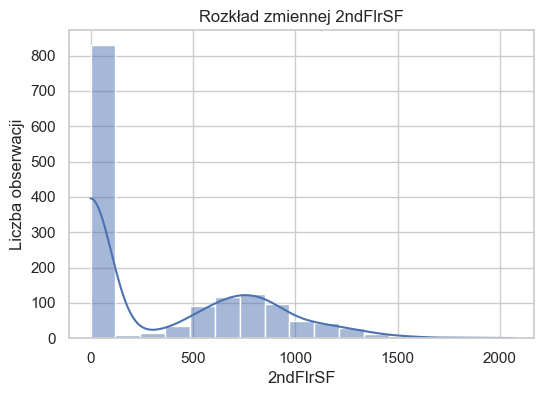

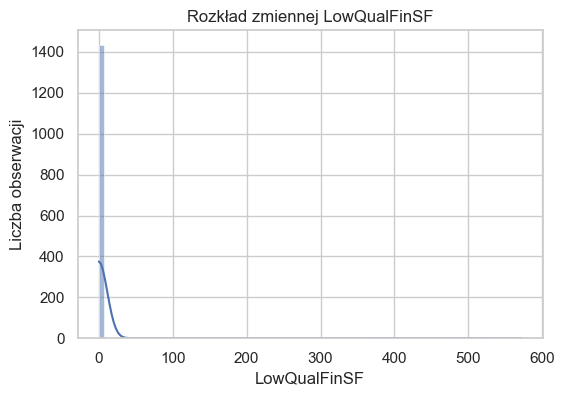

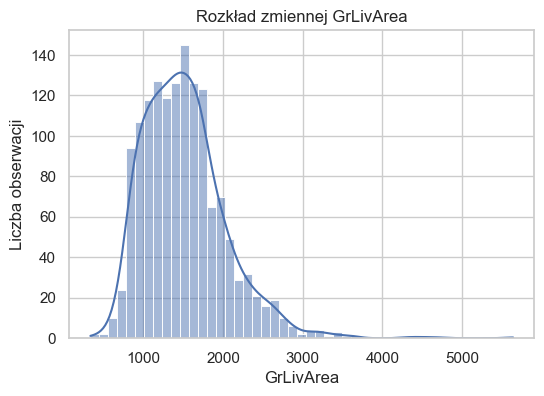

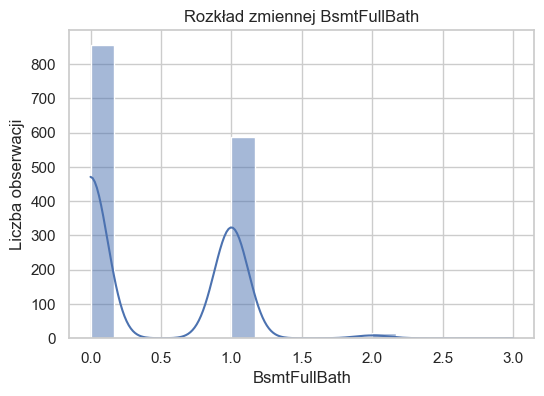

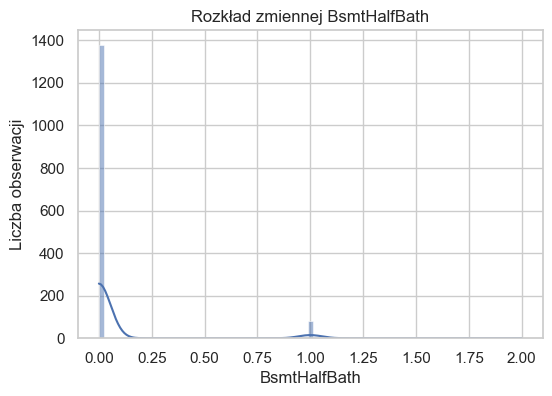

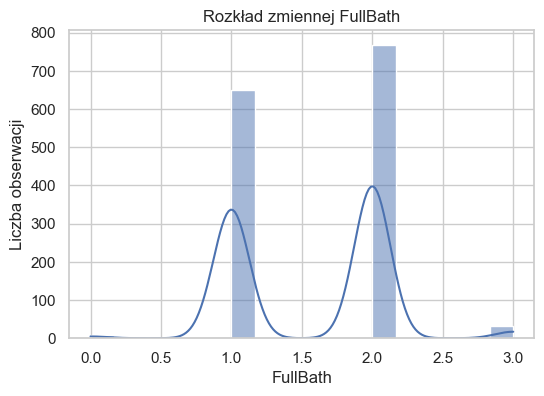

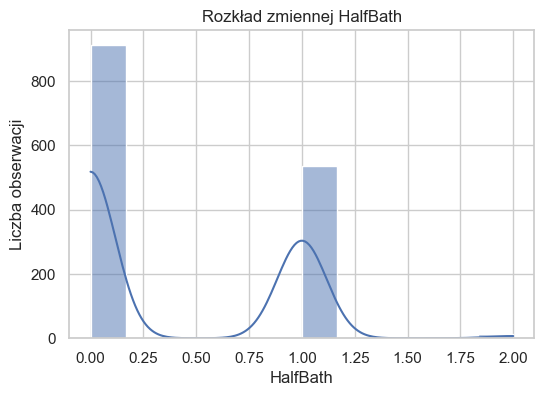

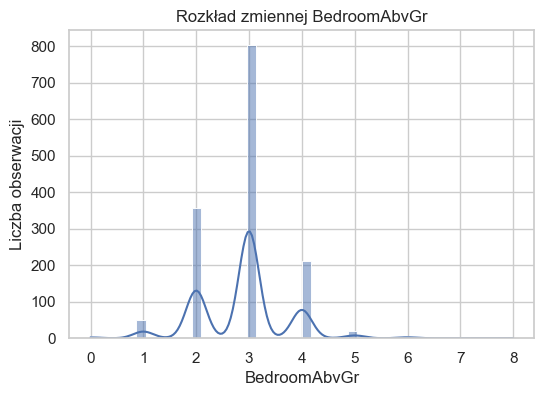

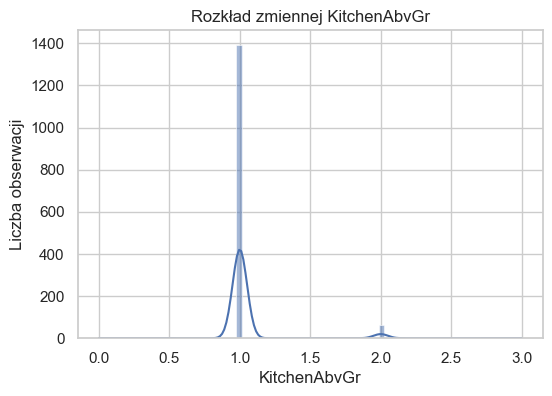

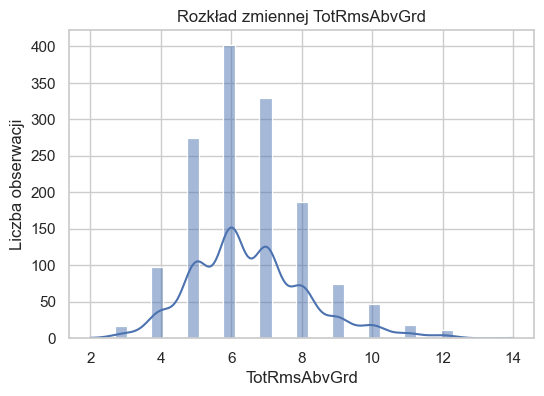

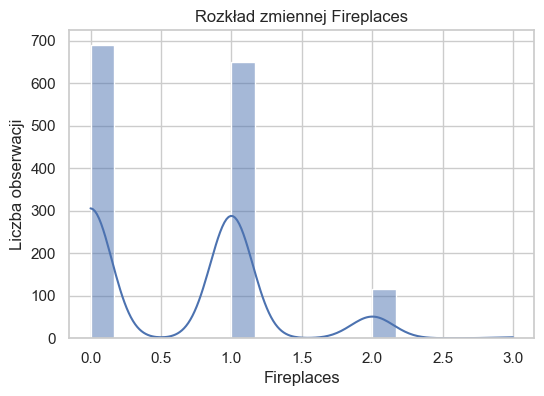

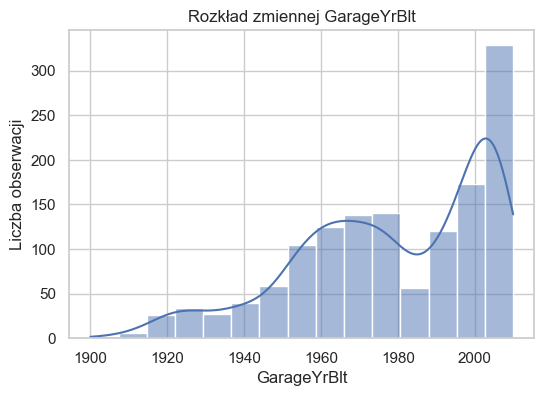

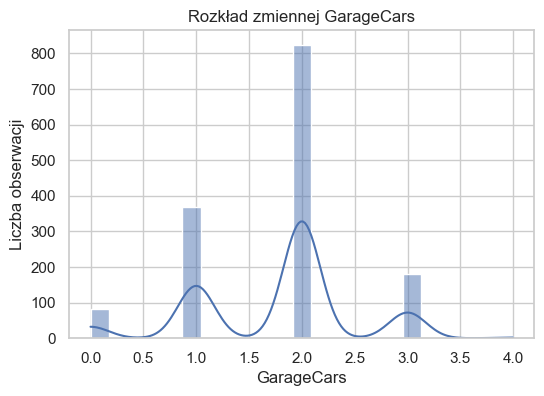

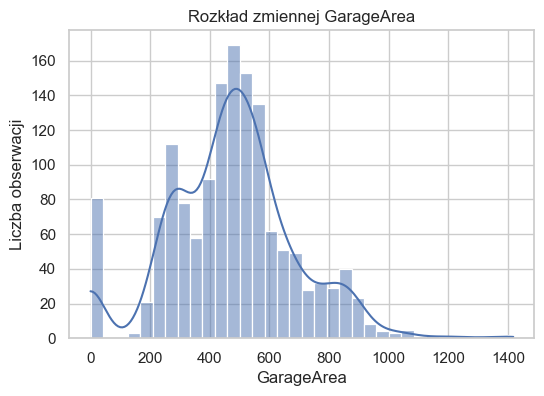

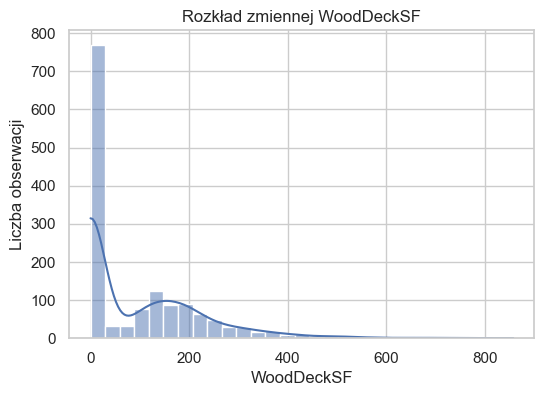

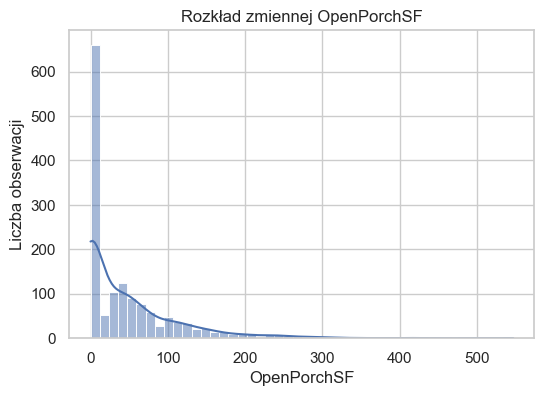

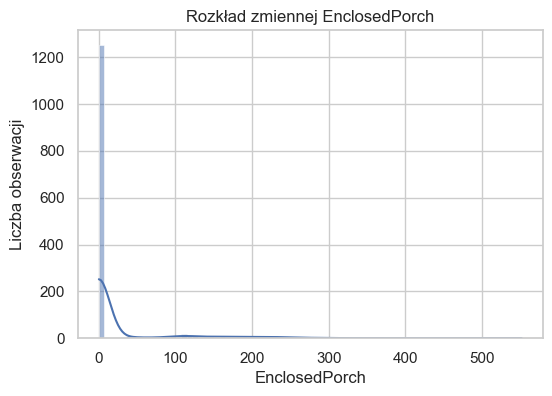

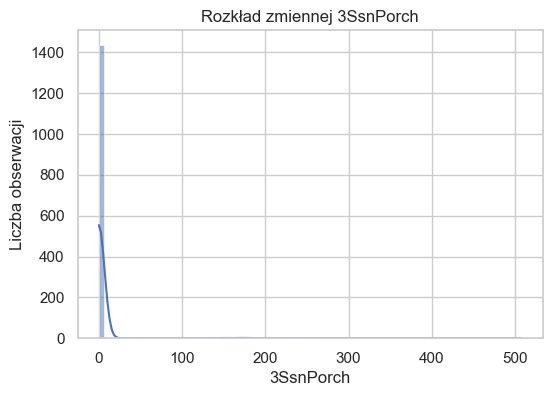

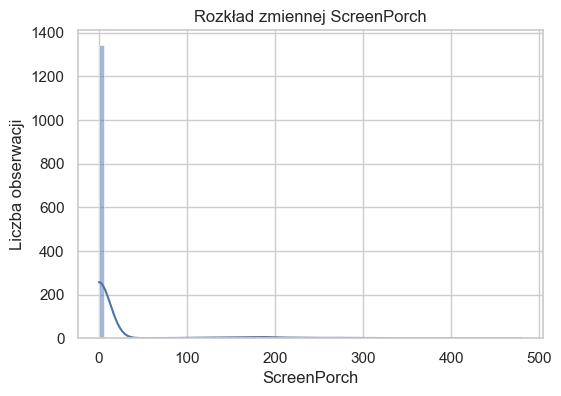

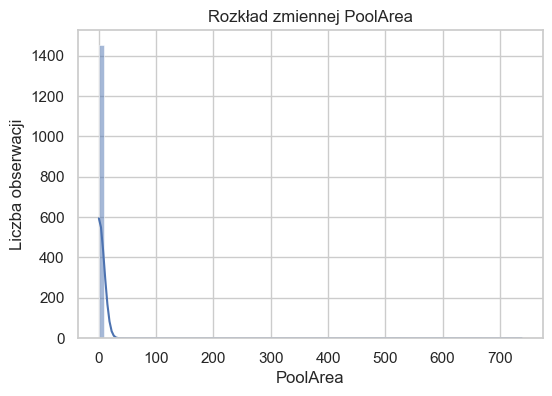

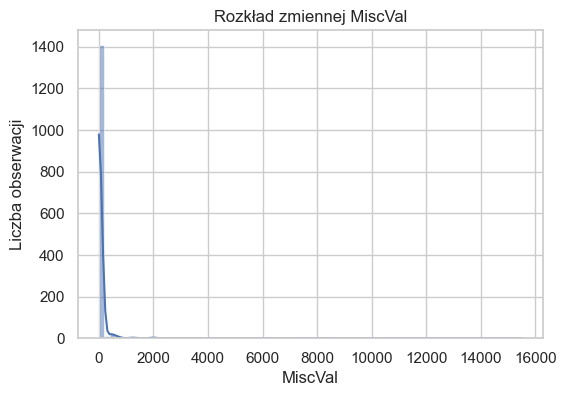

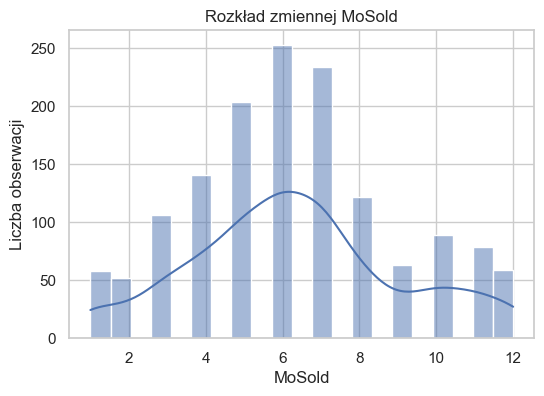

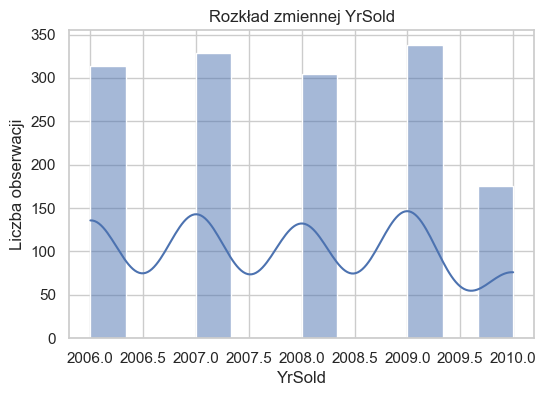

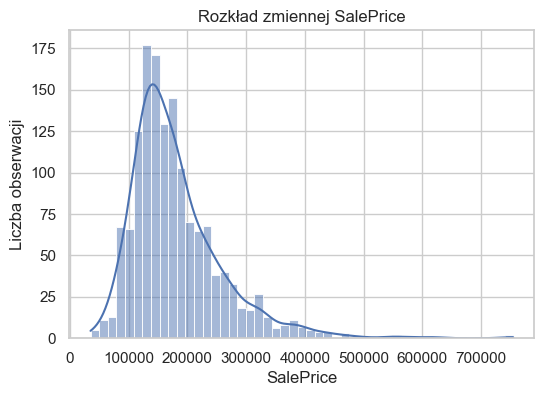

In [17]:
# rozklady zmiennych

for col in num_vars:
    plt.figure(figsize=(6,4))
    sns.histplot(train[col], kde=True)
    plt.title(f'Rozkład zmiennej {col}')
    plt.xlabel(col)
    plt.ylabel('Liczba obserwacji')
    plt.savefig(f'../plots/dist/dist_{col}.png')
    plt.show()

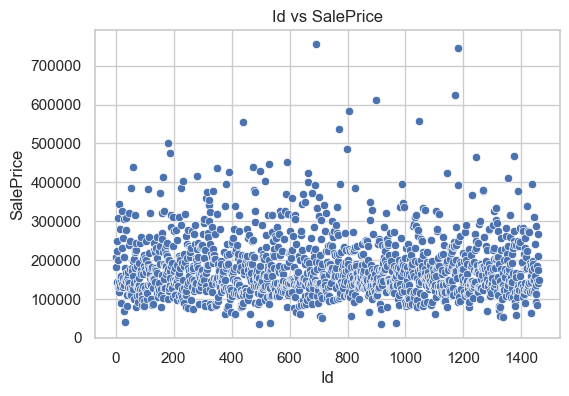

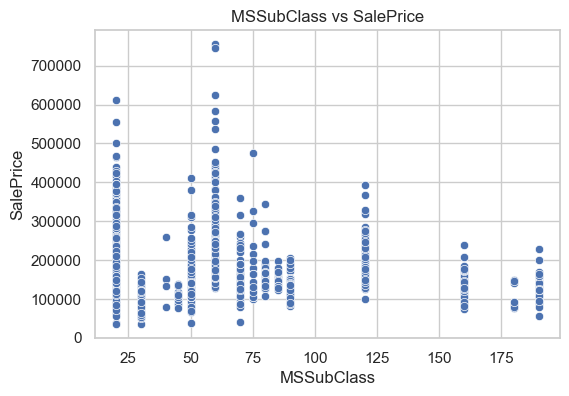

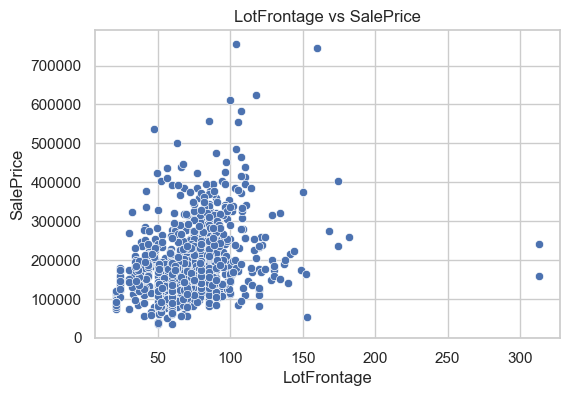

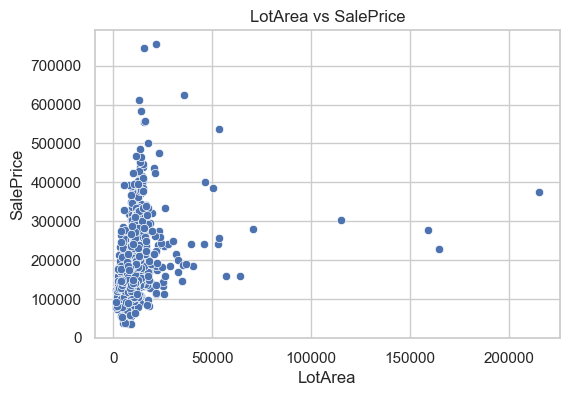

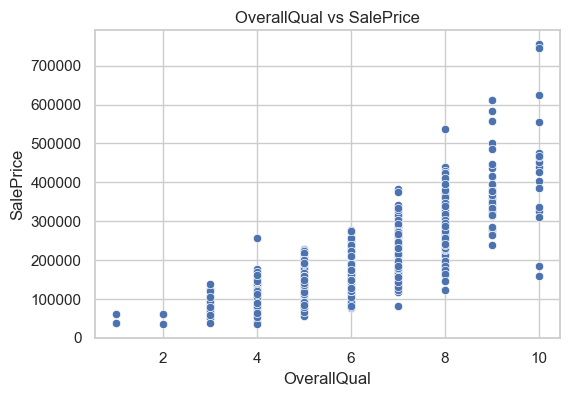

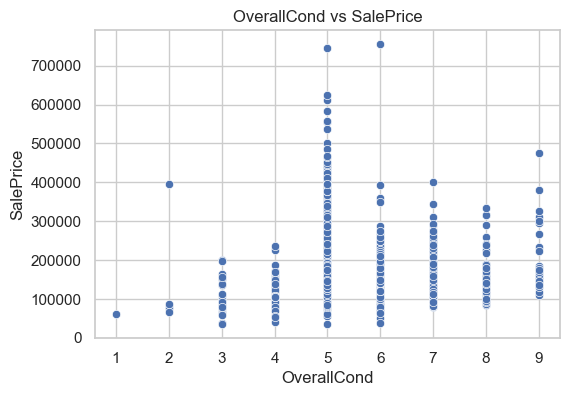

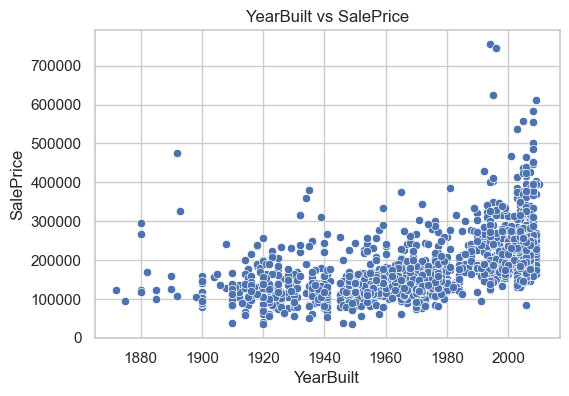

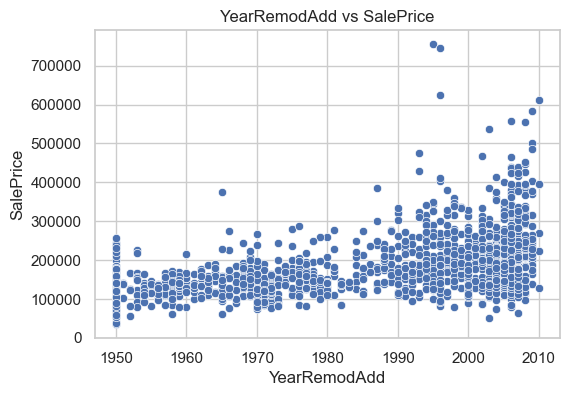

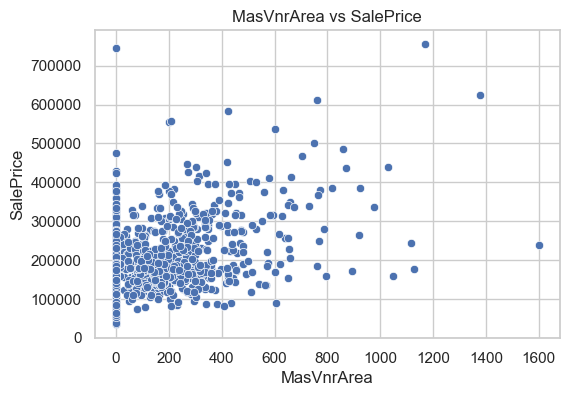

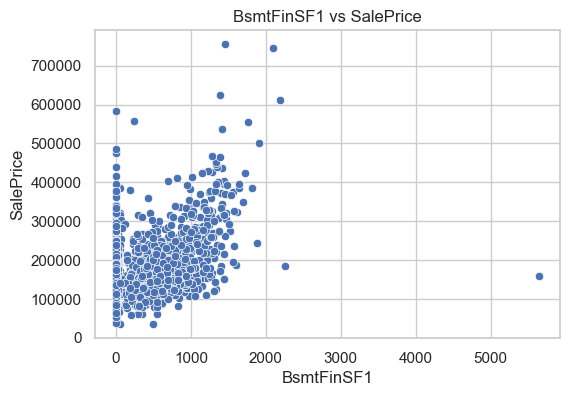

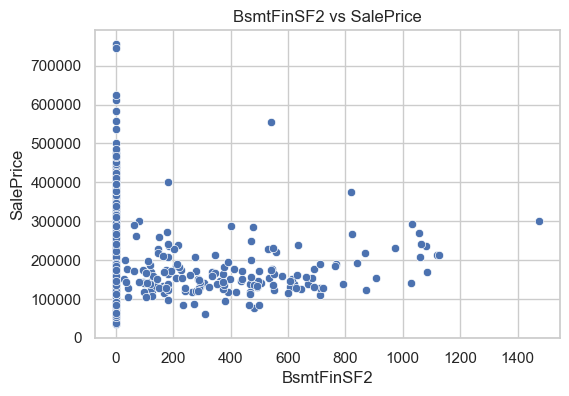

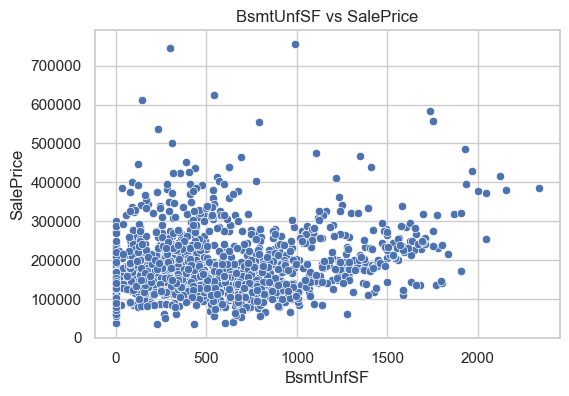

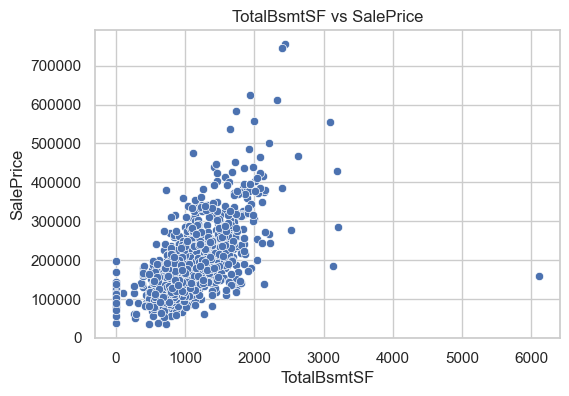

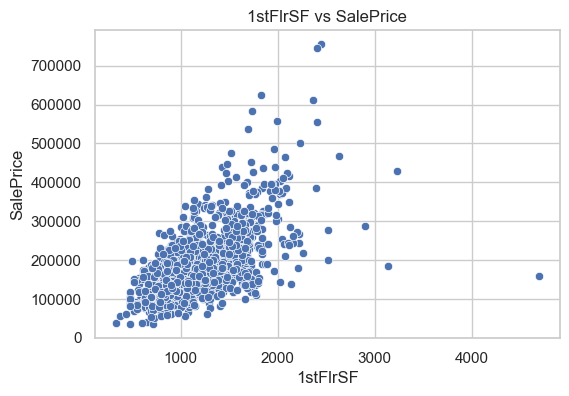

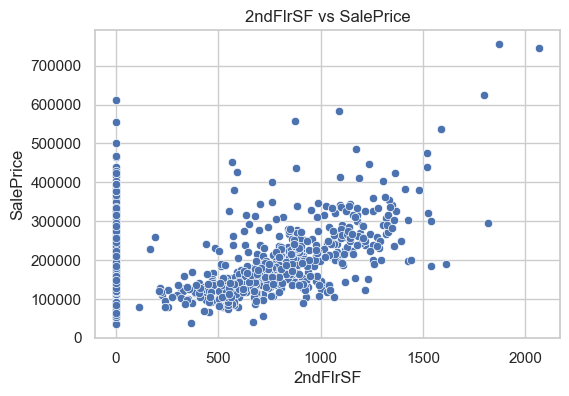

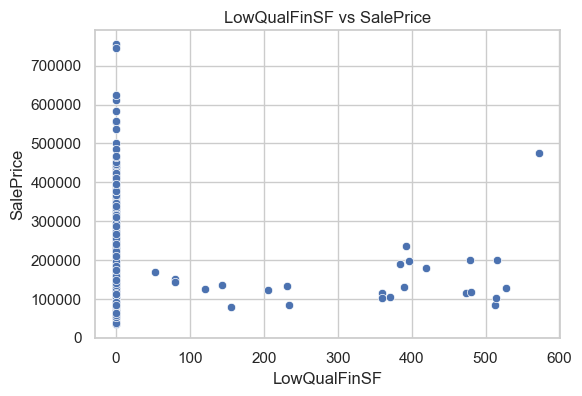

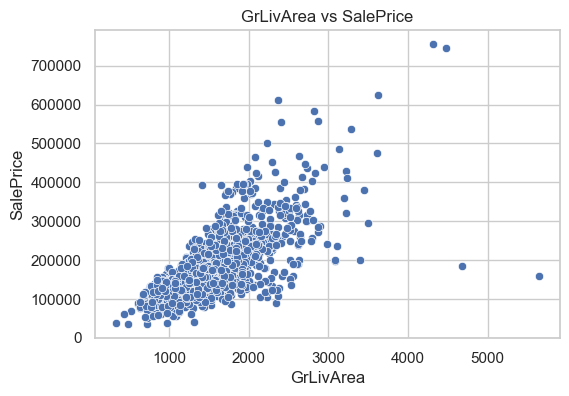

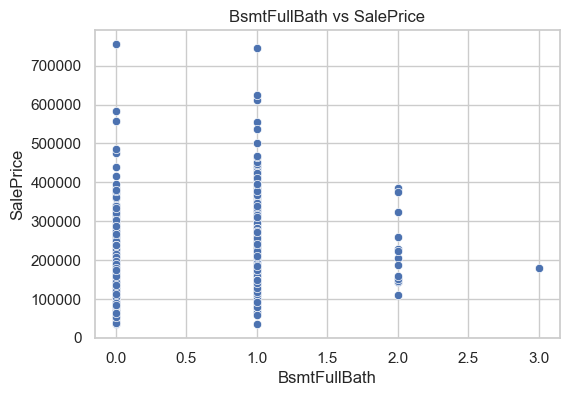

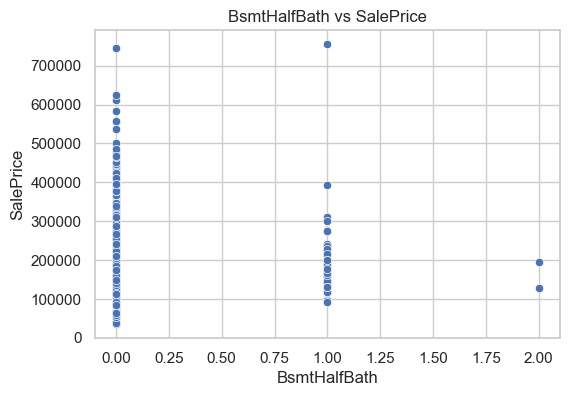

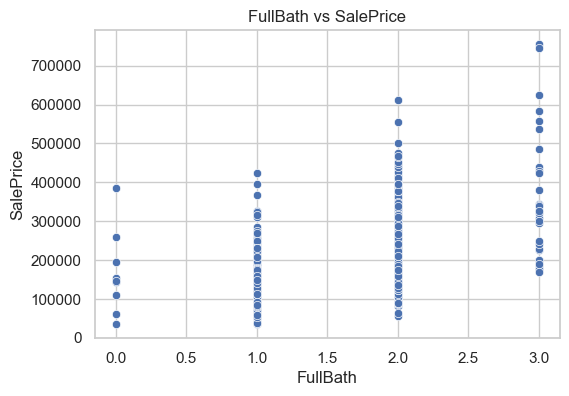

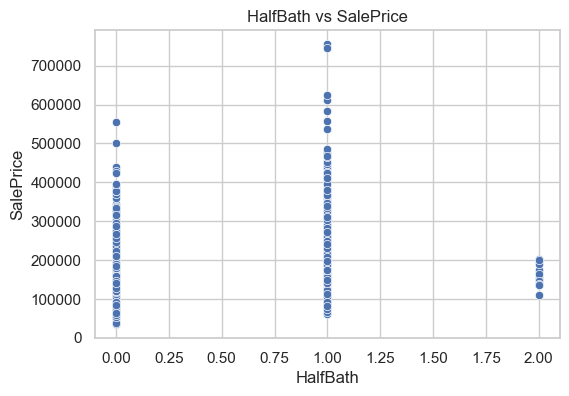

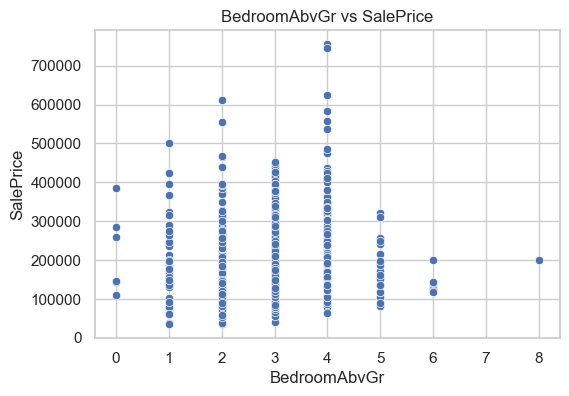

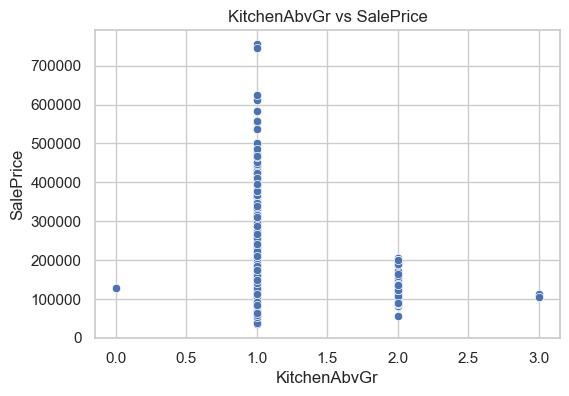

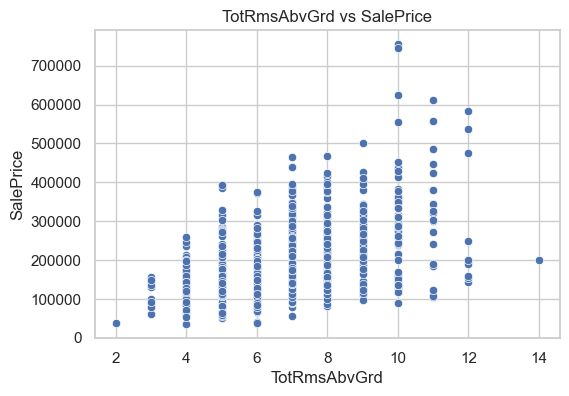

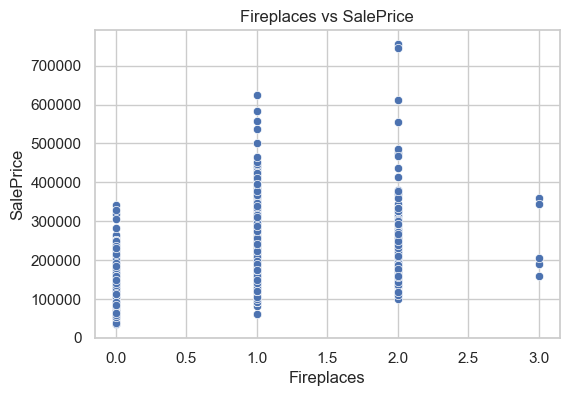

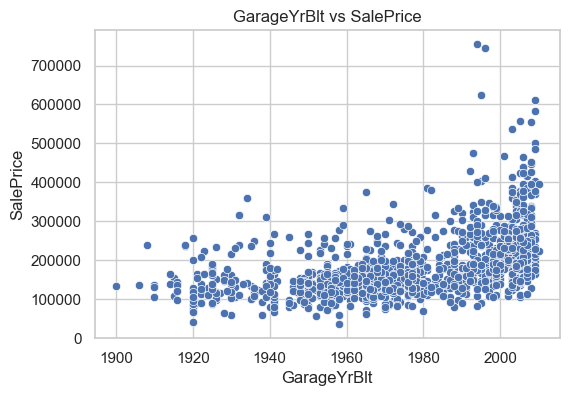

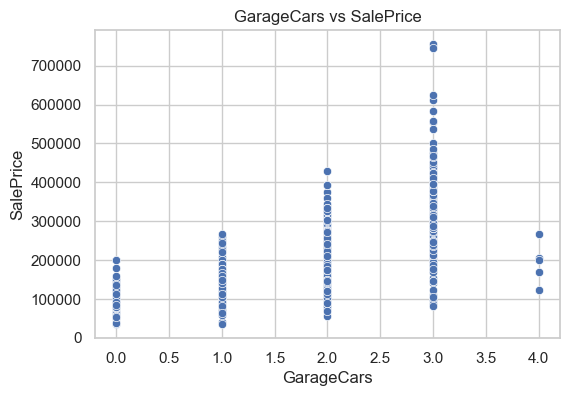

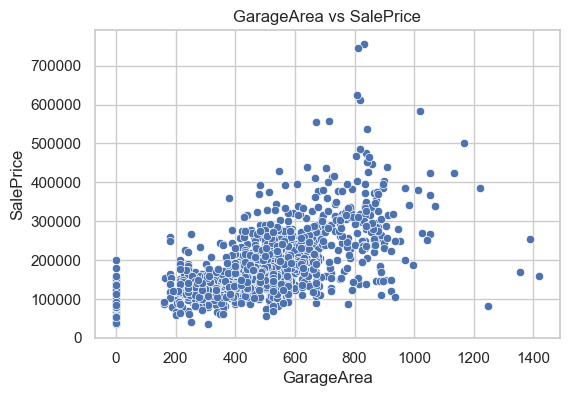

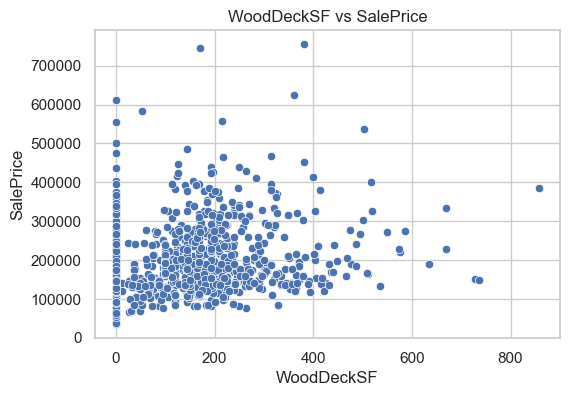

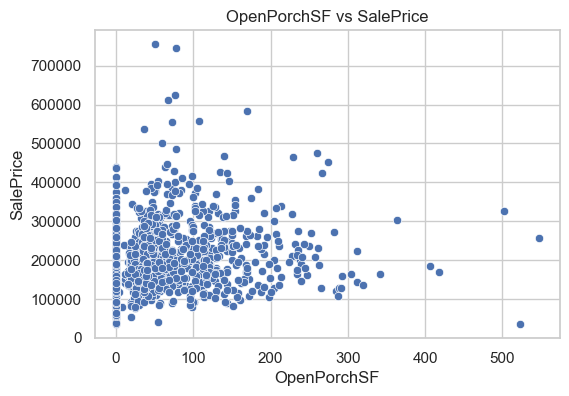

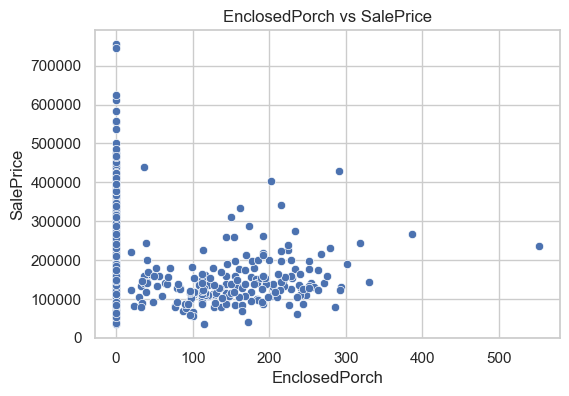

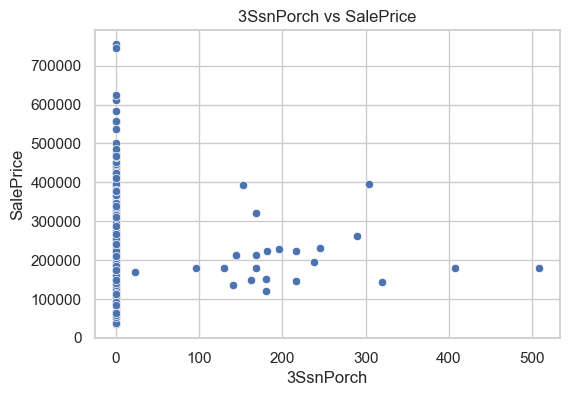

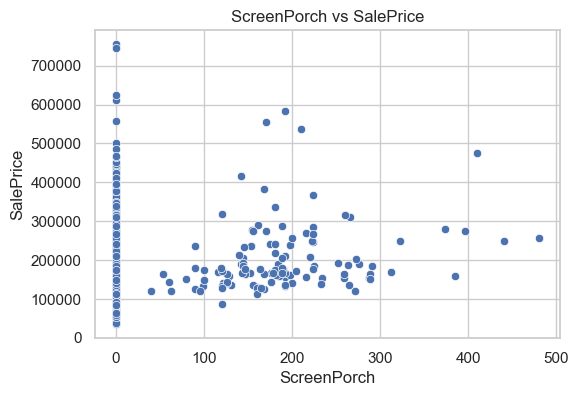

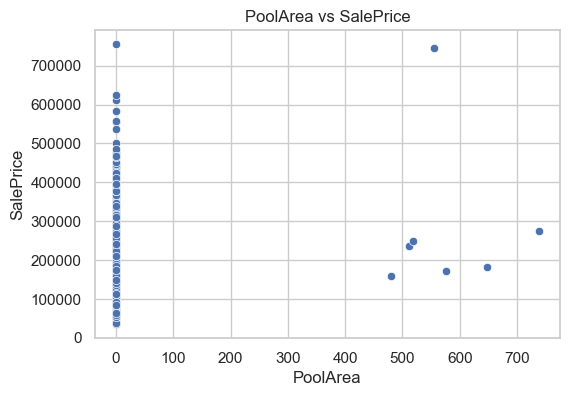

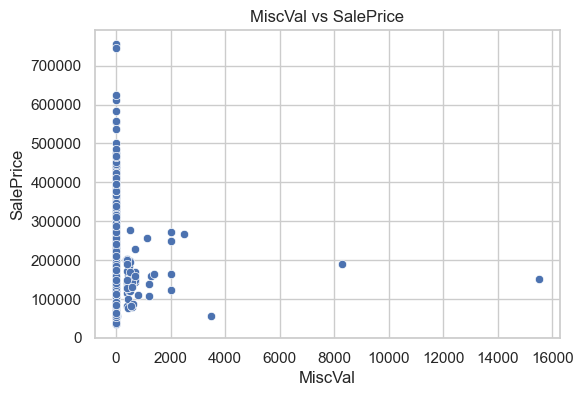

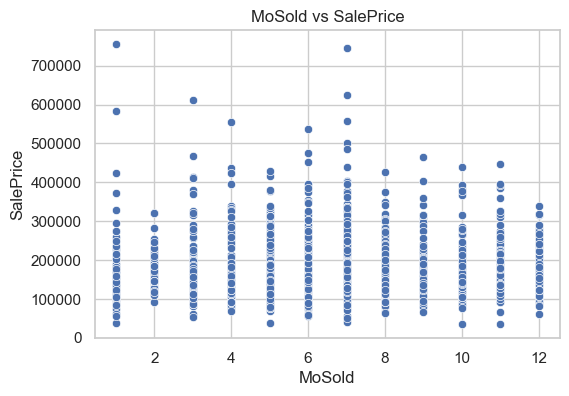

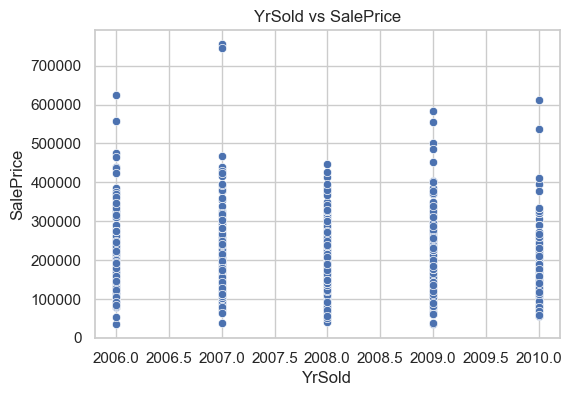

In [19]:
# zależność zmiennych od ceny SalePrice

for col in num_vars:
    if col != 'SalePrice':
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=train[col], y=train['SalePrice'])
        plt.title(f'{col} vs SalePrice')
        plt.xlabel(col)
        plt.ylabel('SalePrice')
        plt.savefig(f'../plots/dep_saleprice/saleprice_vs_{col}.png')
        plt.show()


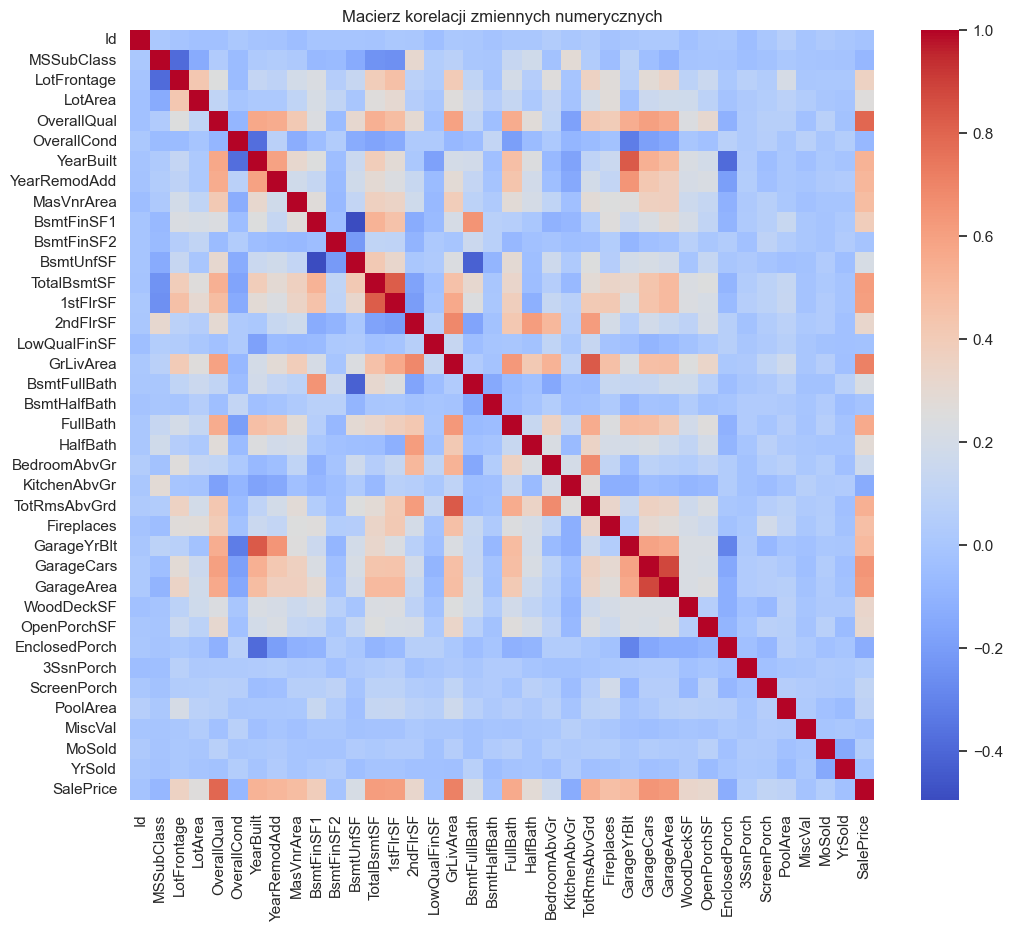

In [21]:
# macierz korelacji
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Macierz korelacji zmiennych numerycznych')
plt.savefig('../plots/corr_matrix.png')
plt.show()


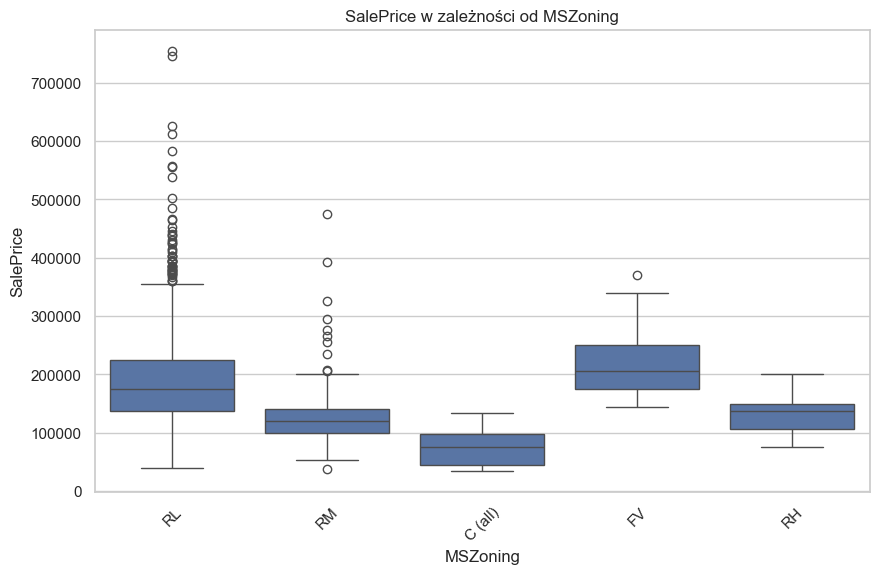

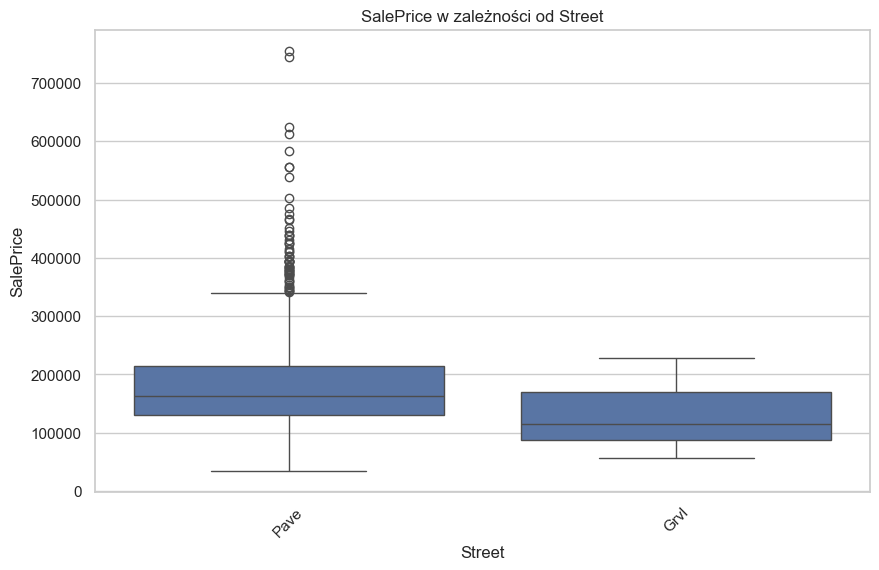

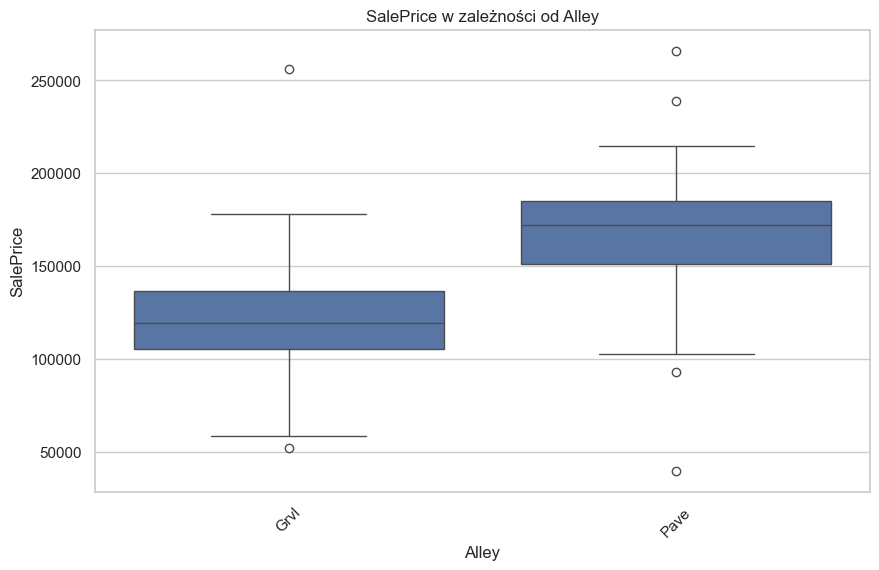

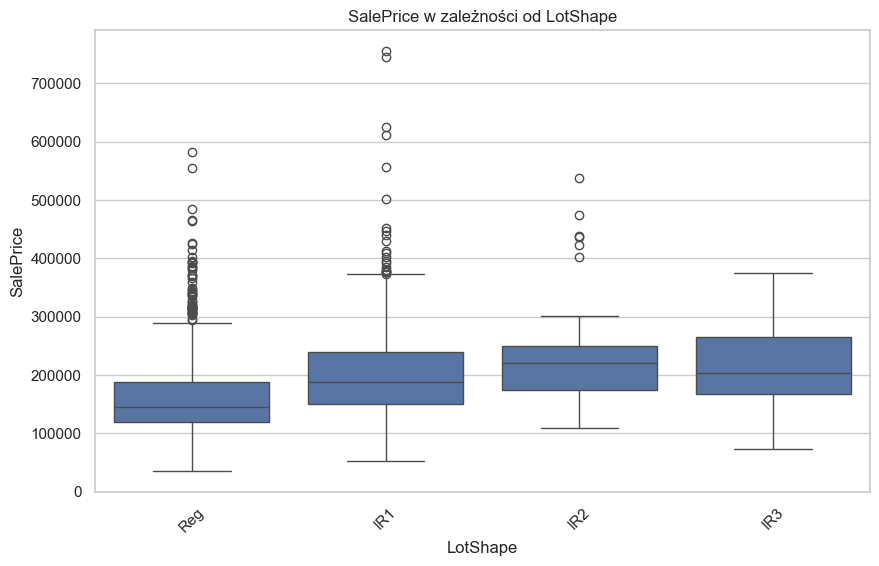

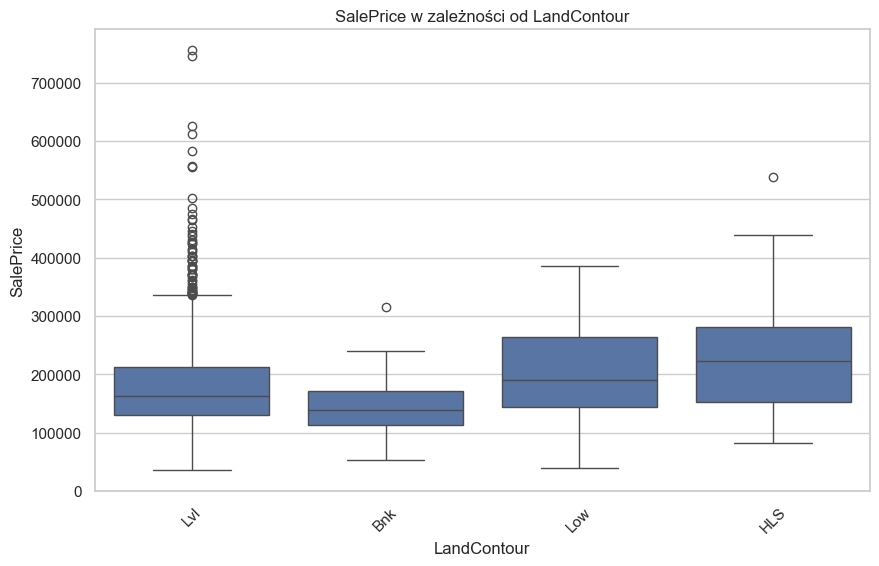

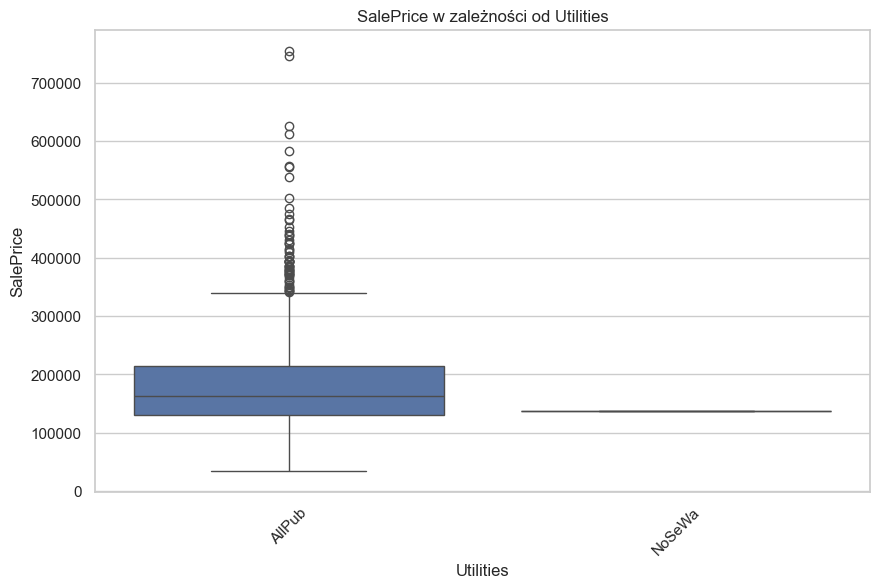

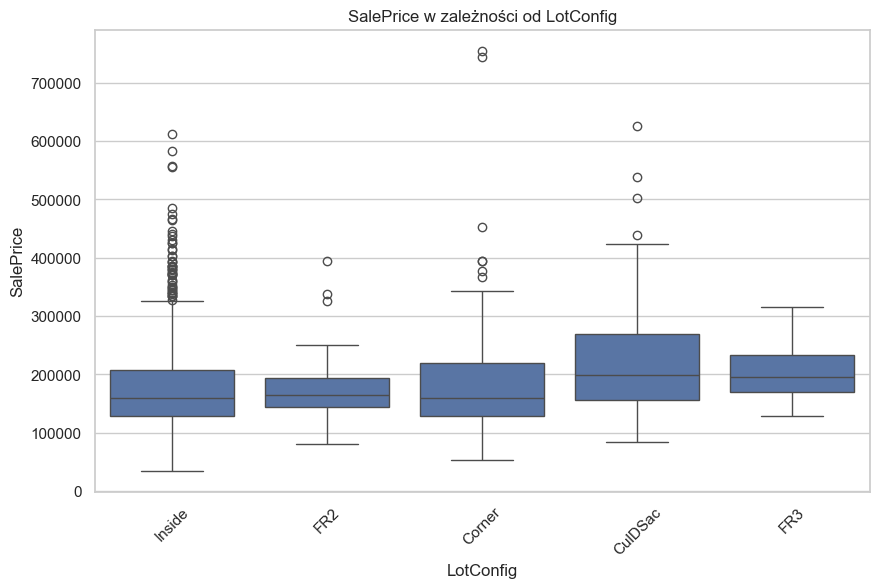

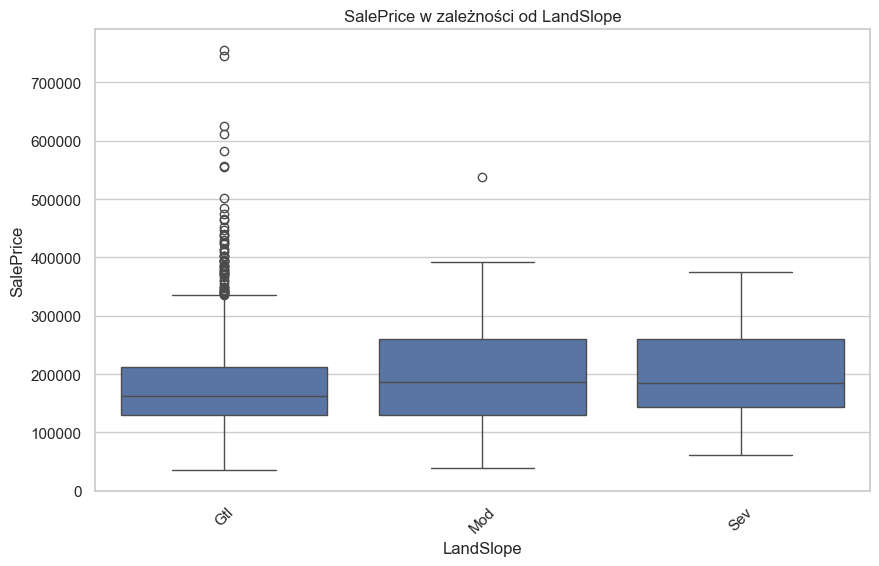

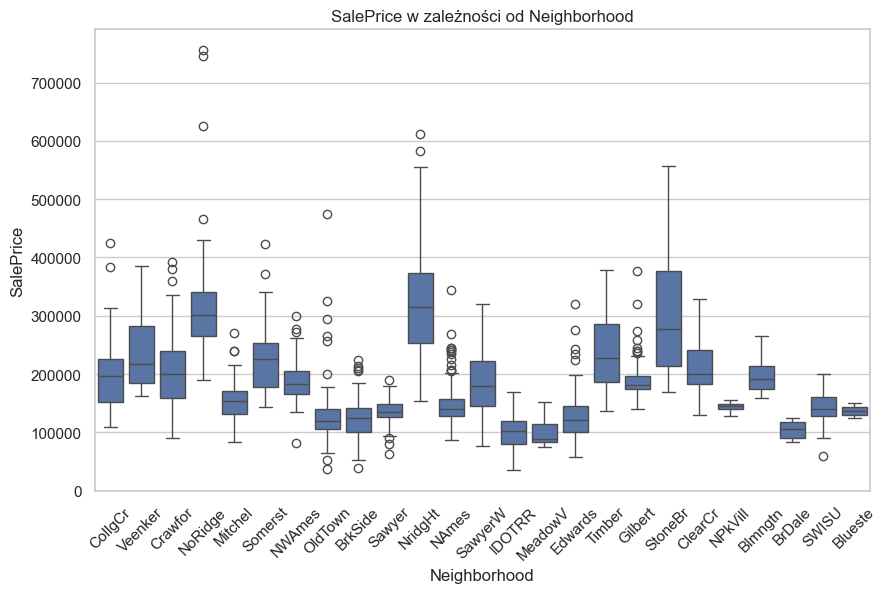

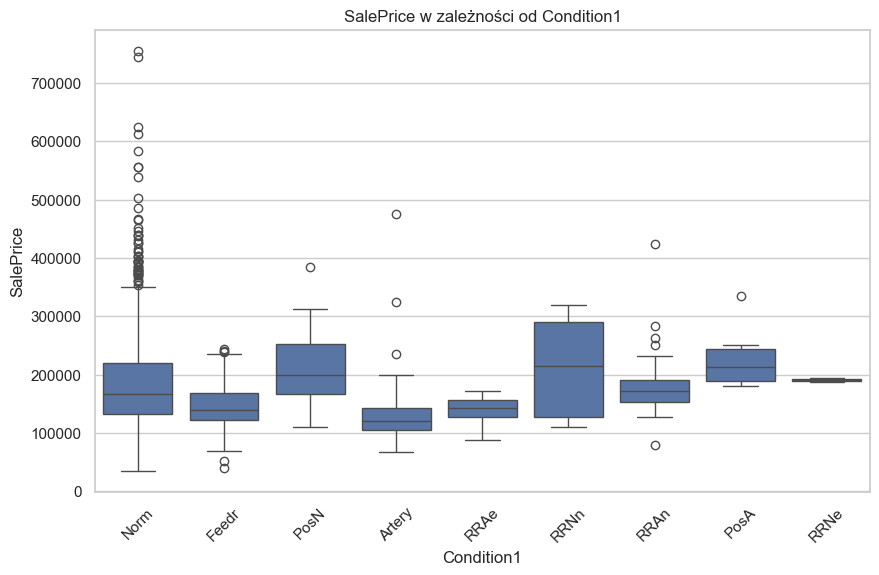

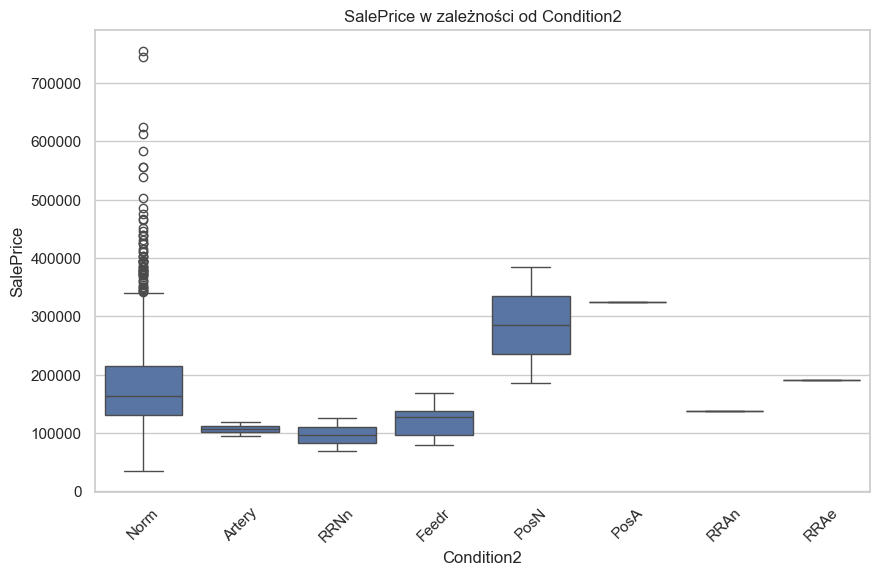

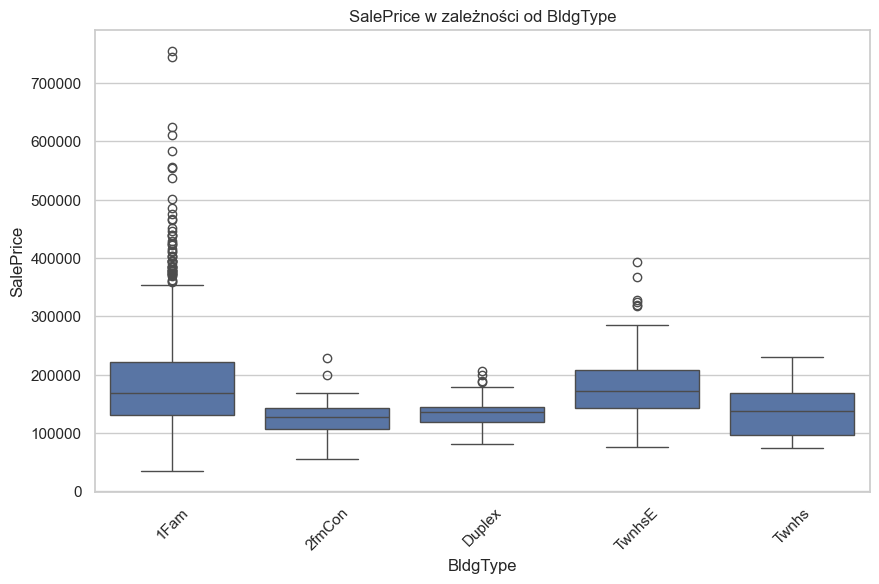

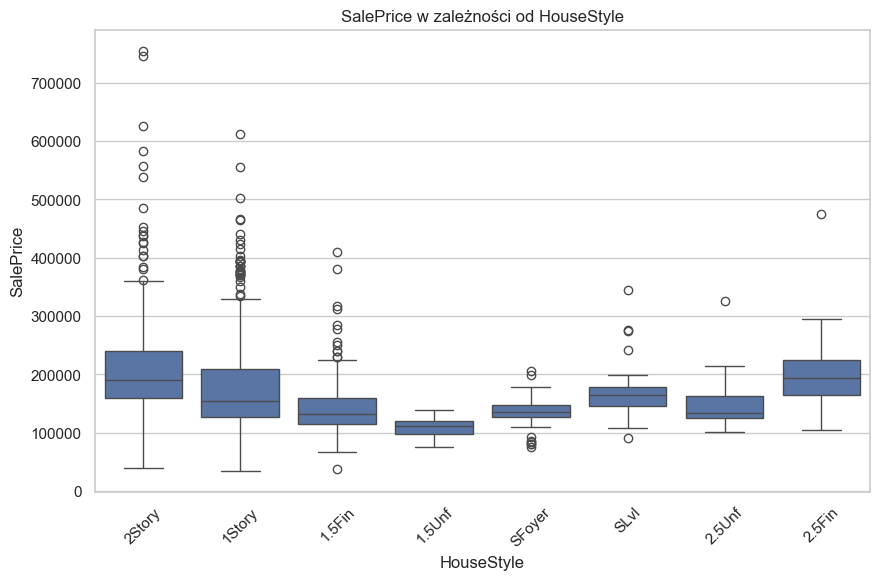

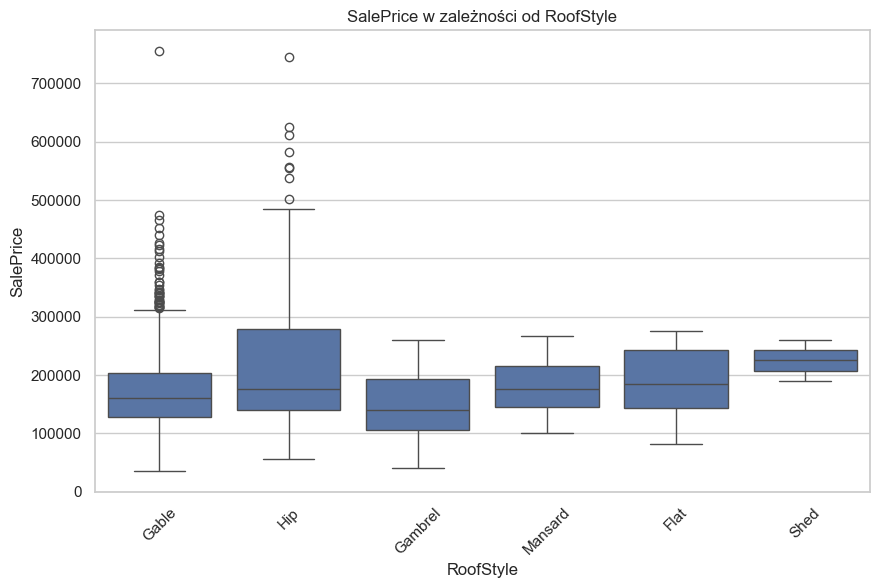

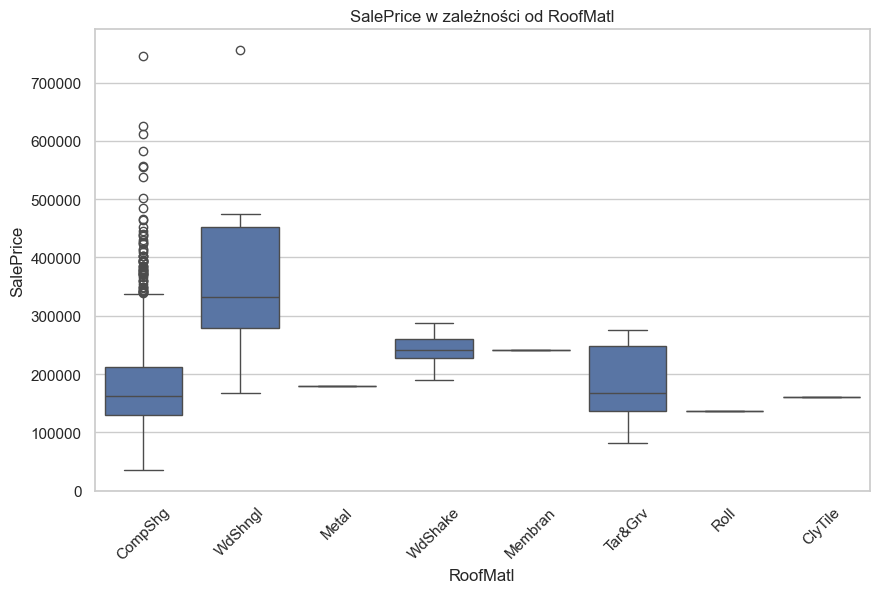

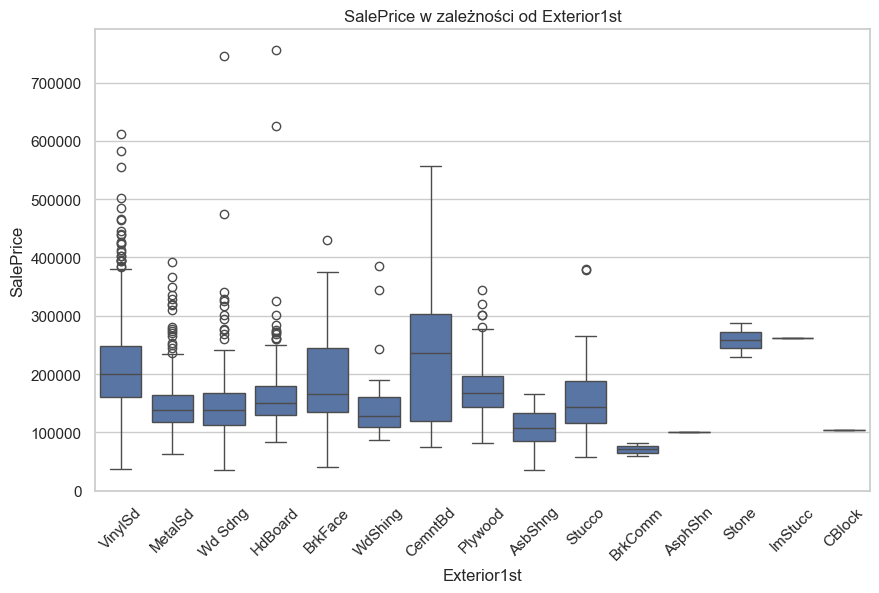

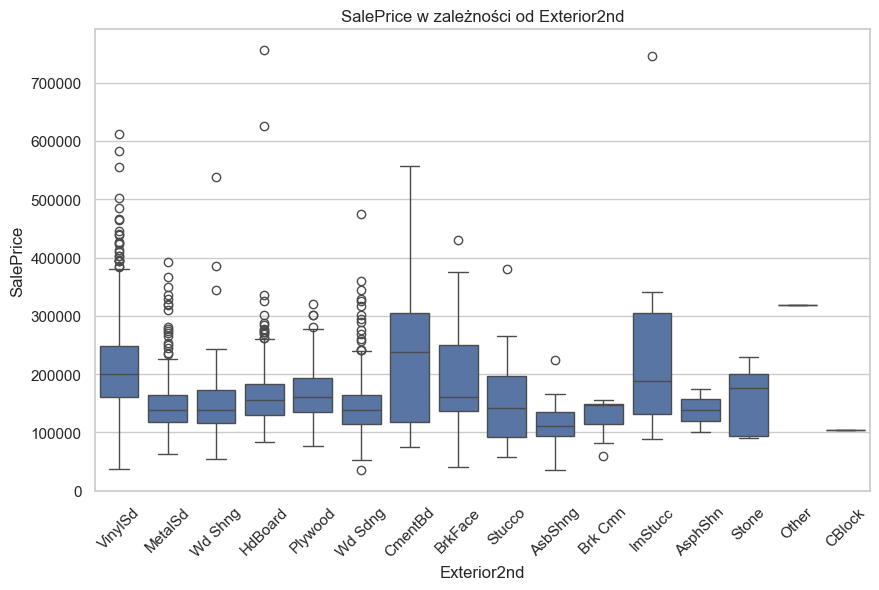

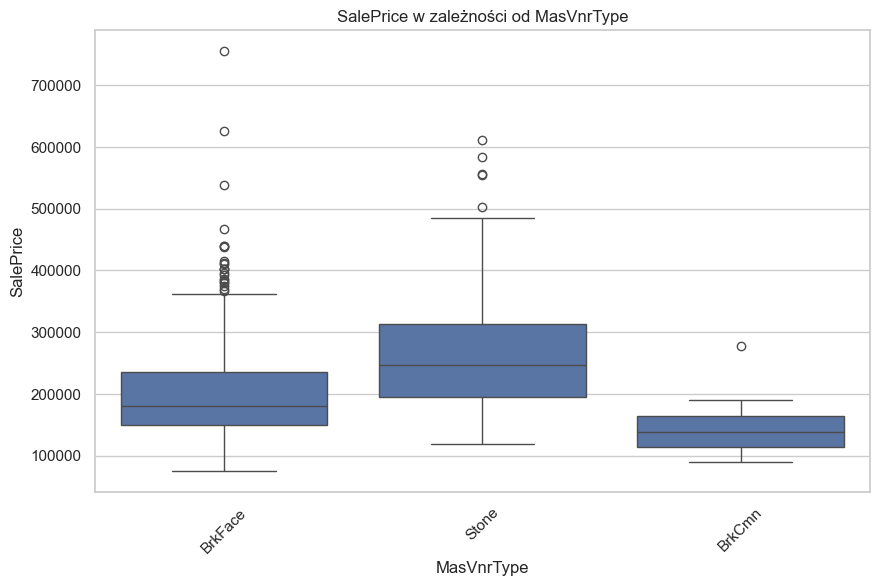

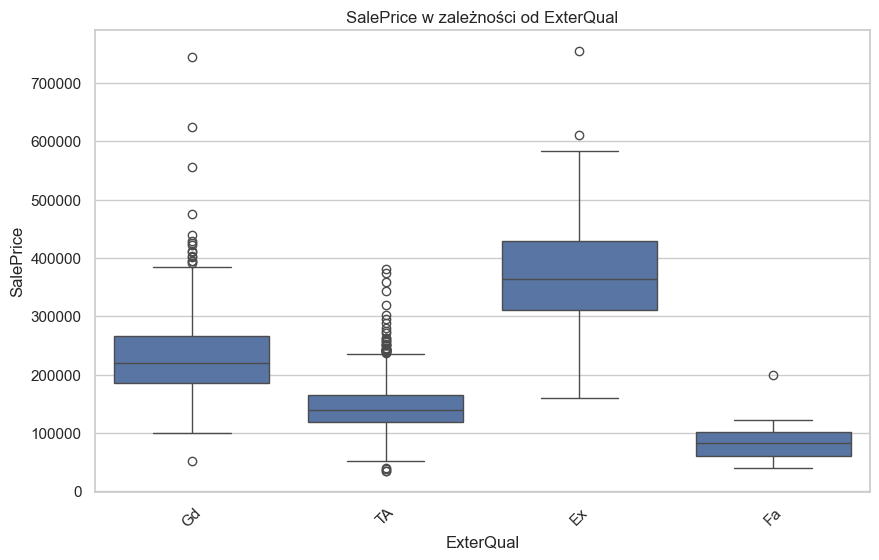

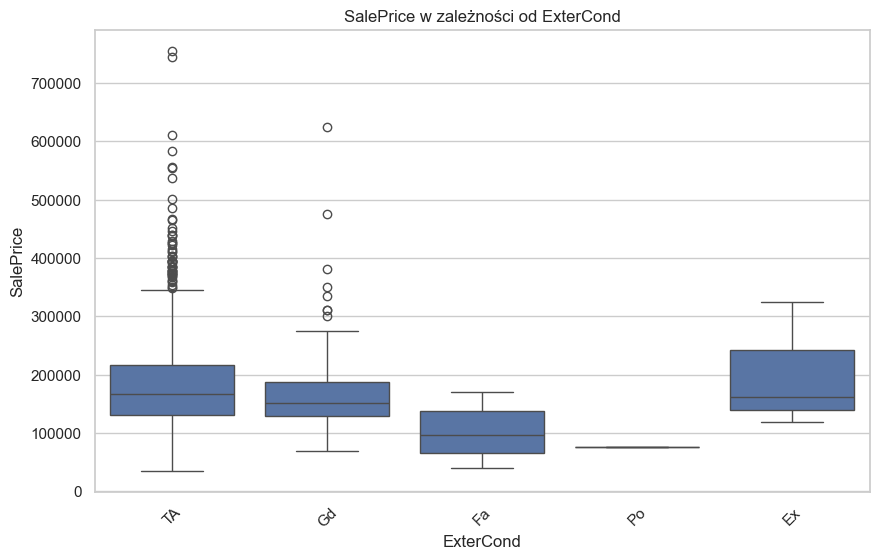

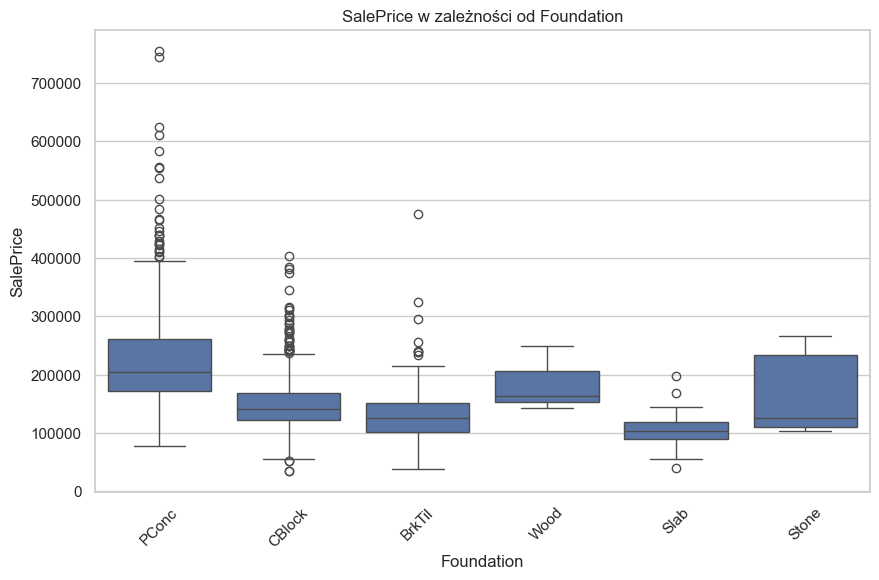

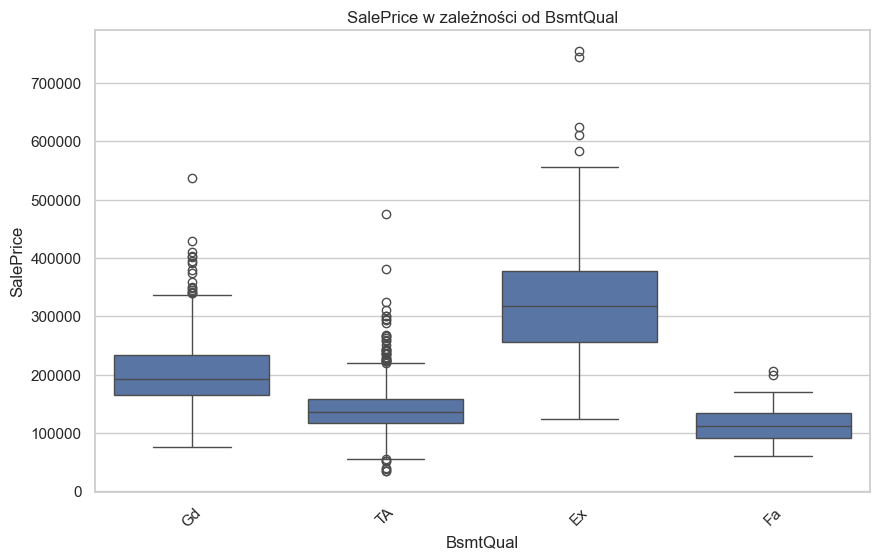

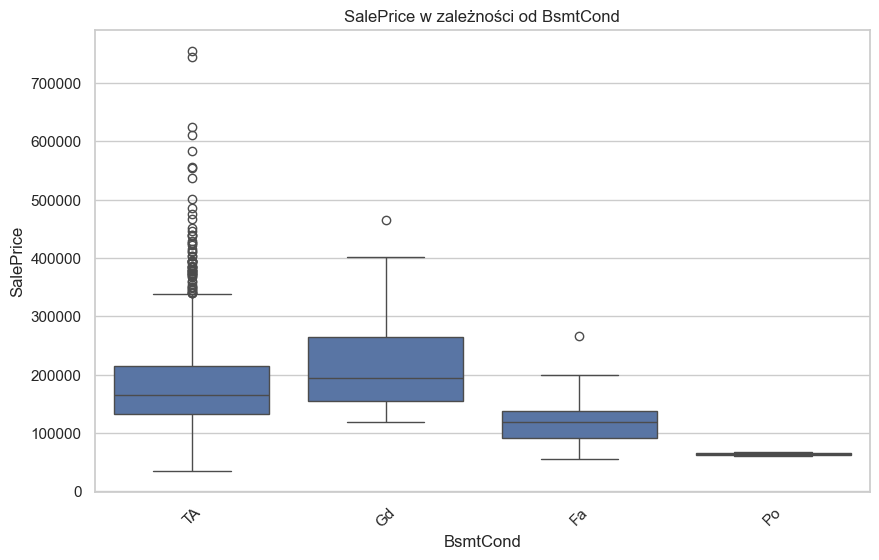

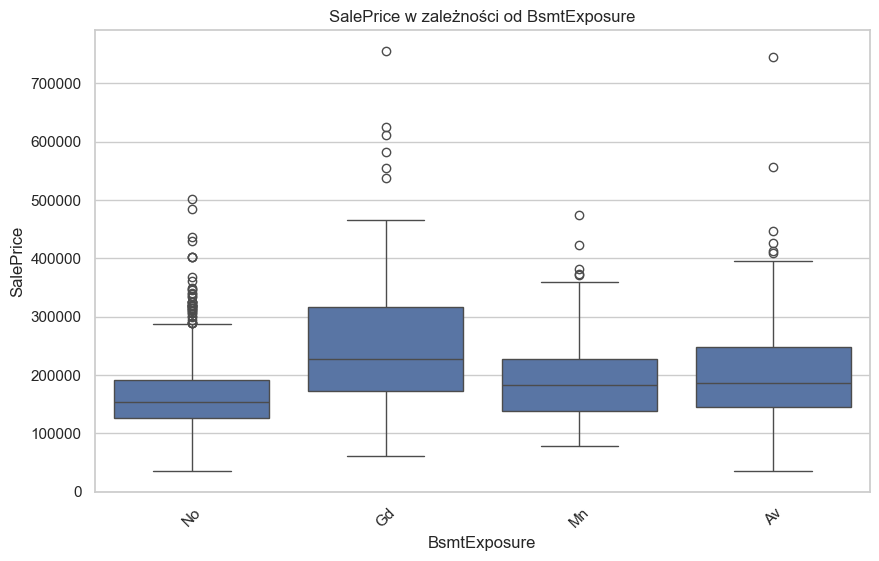

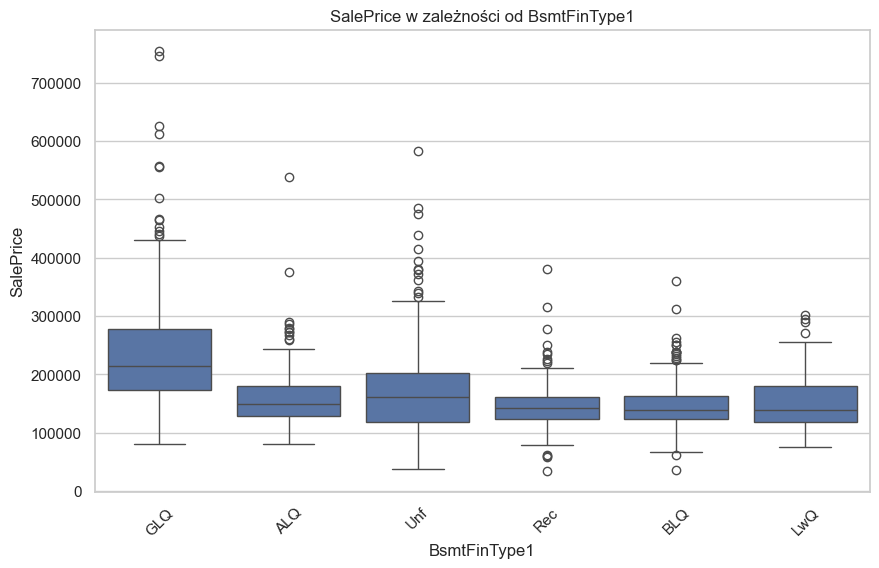

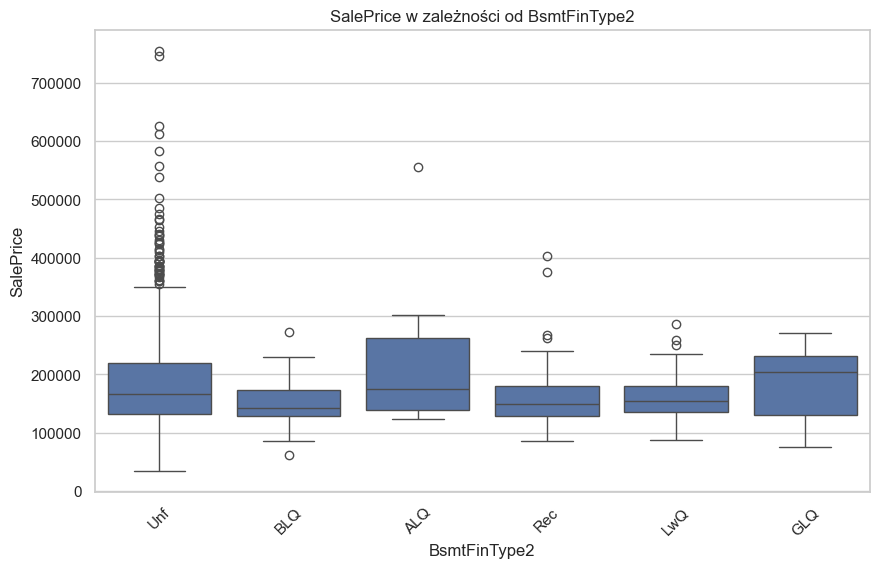

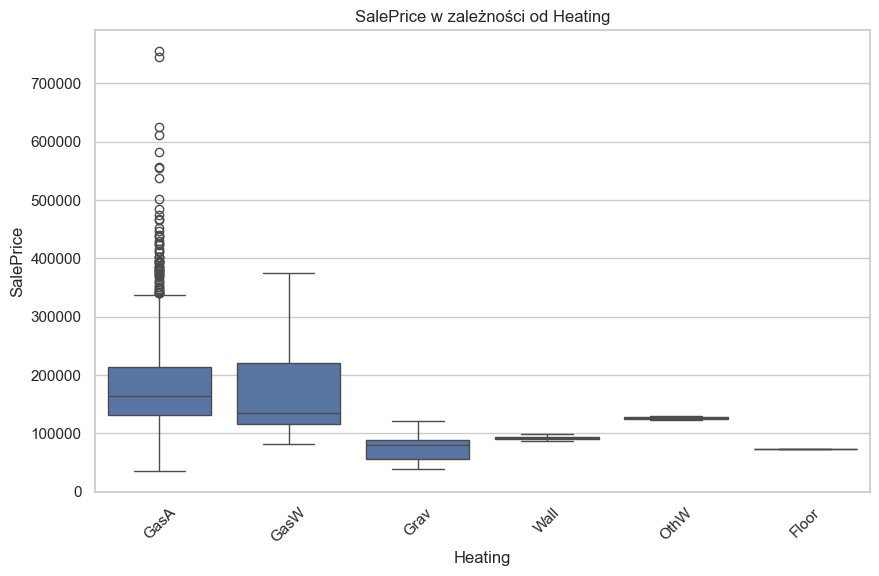

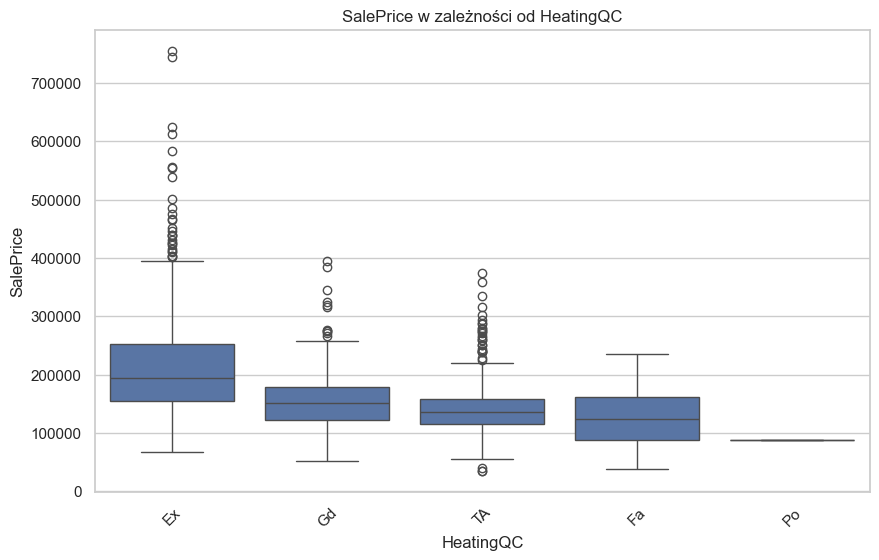

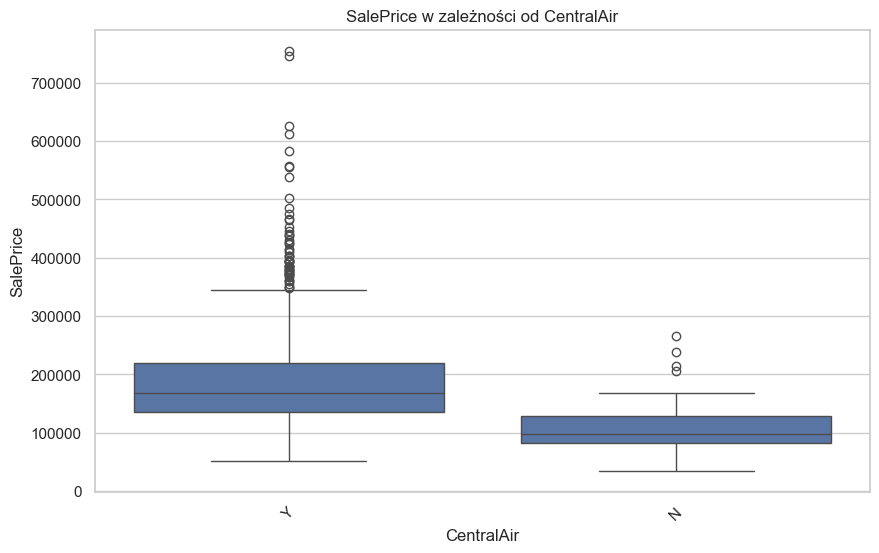

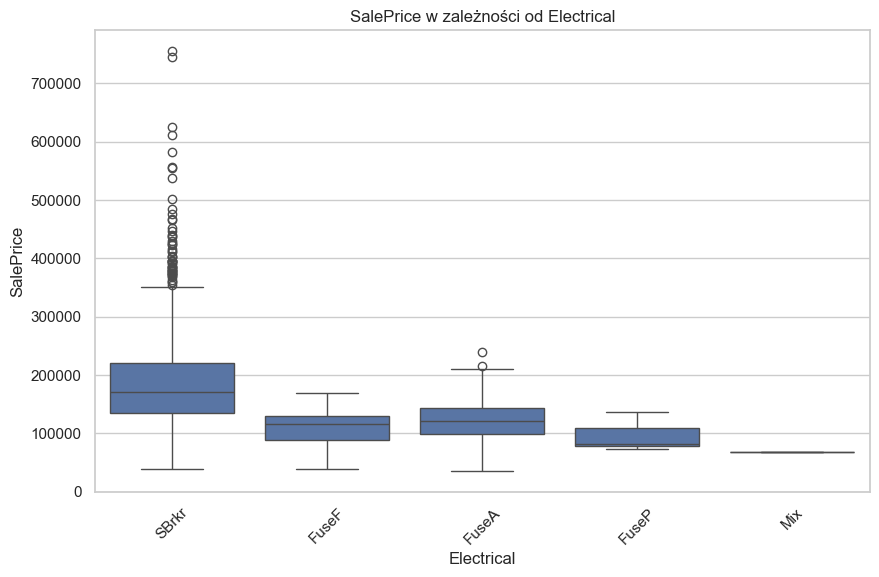

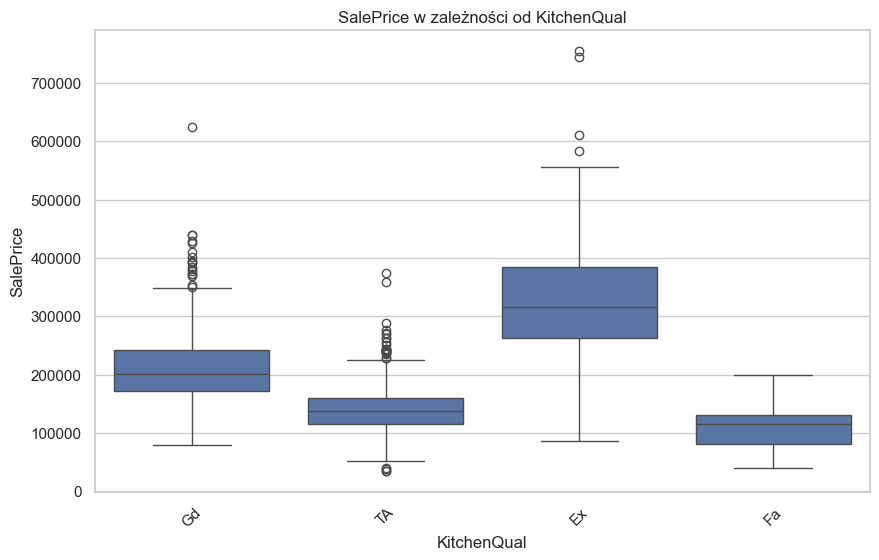

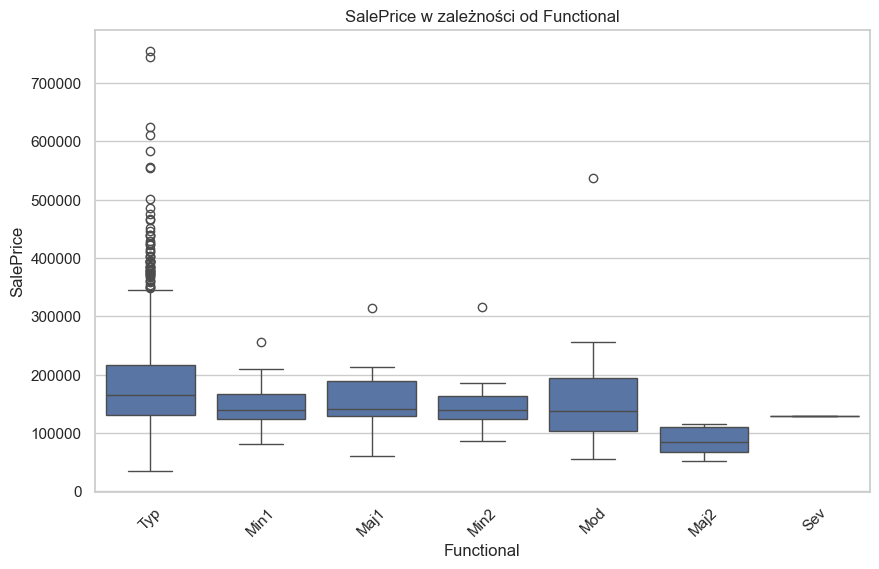

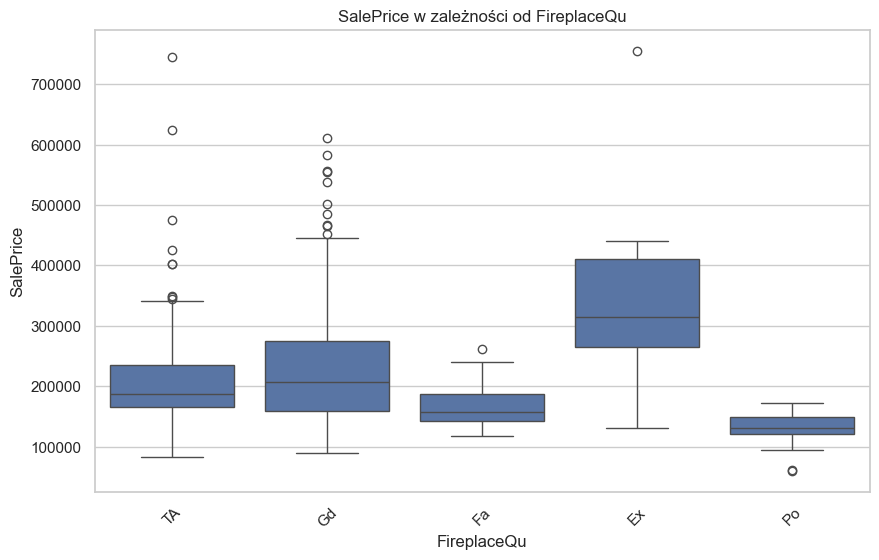

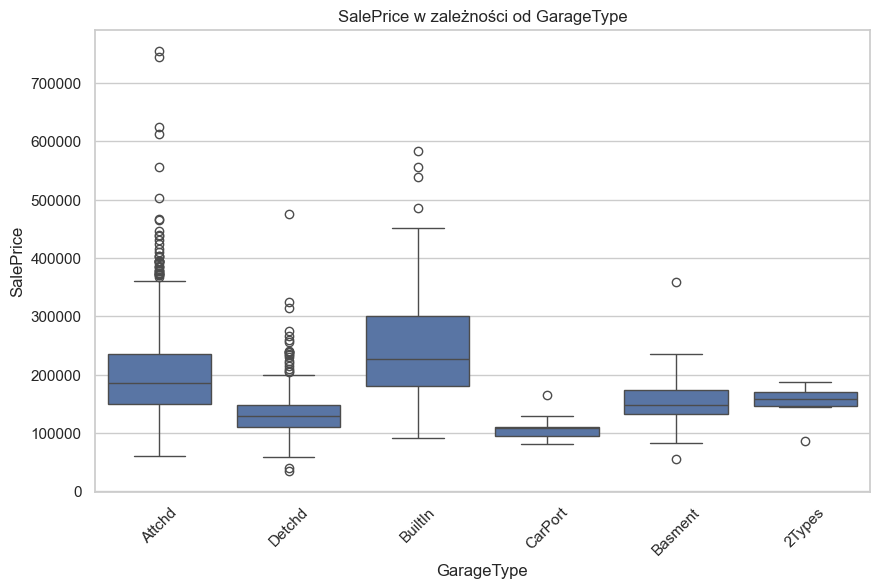

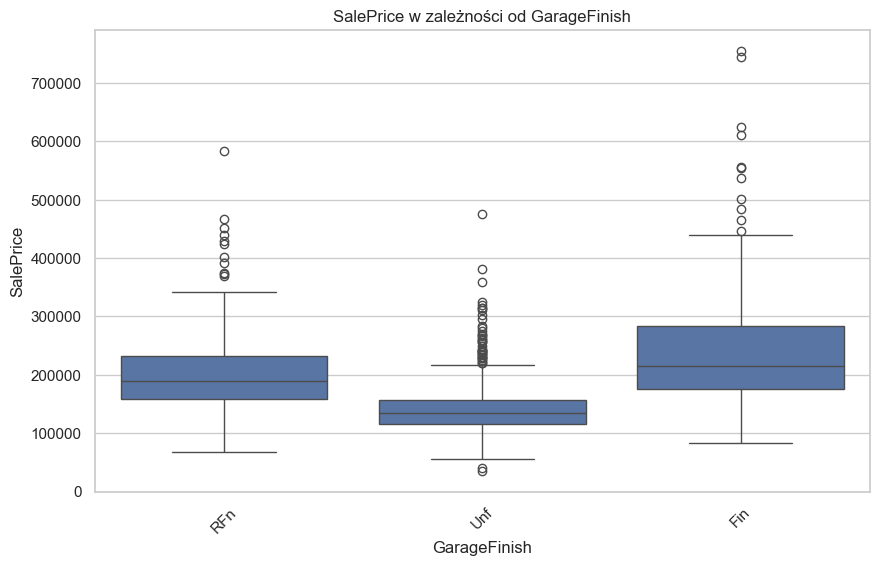

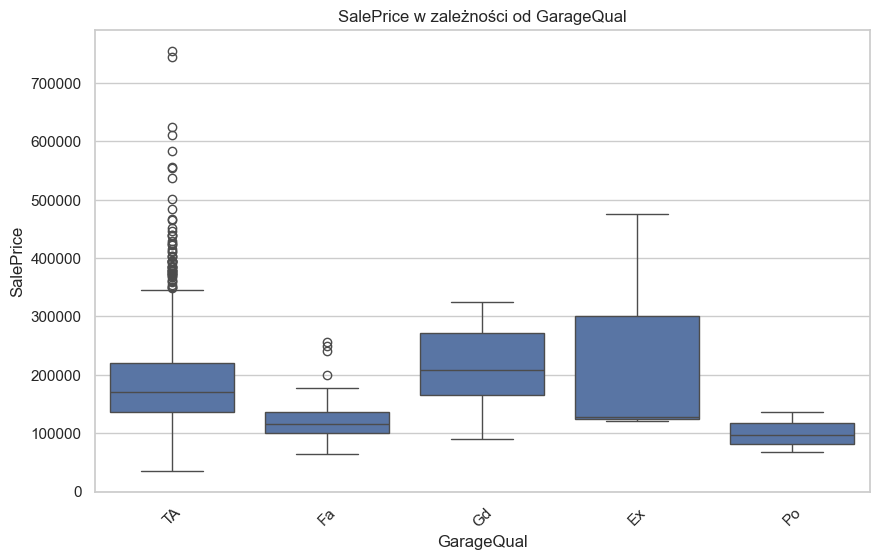

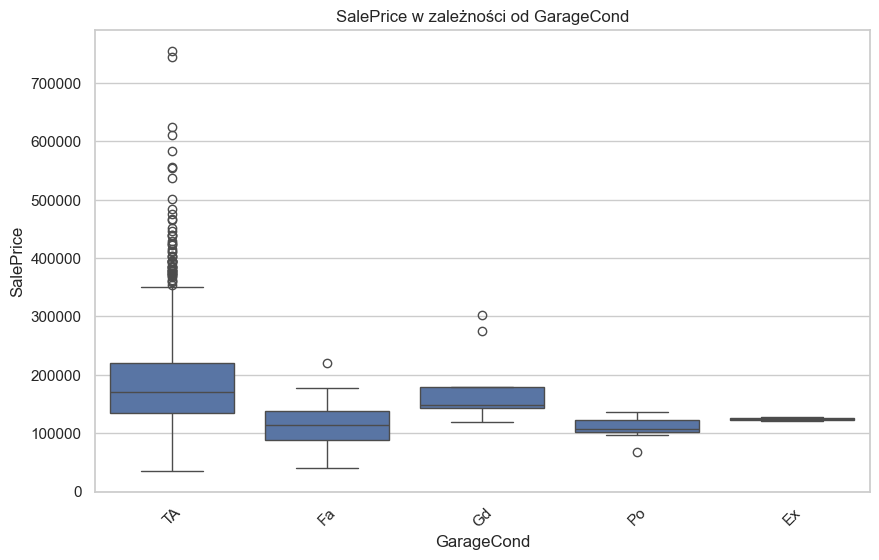

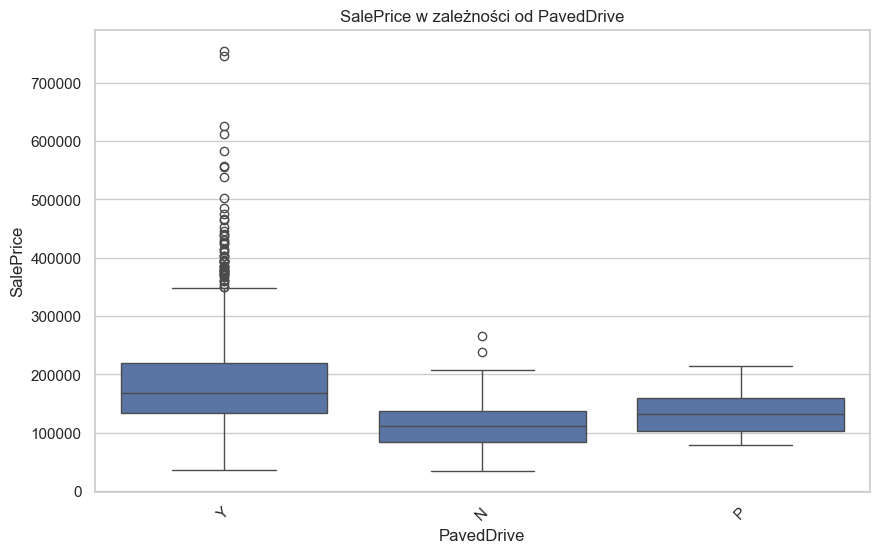

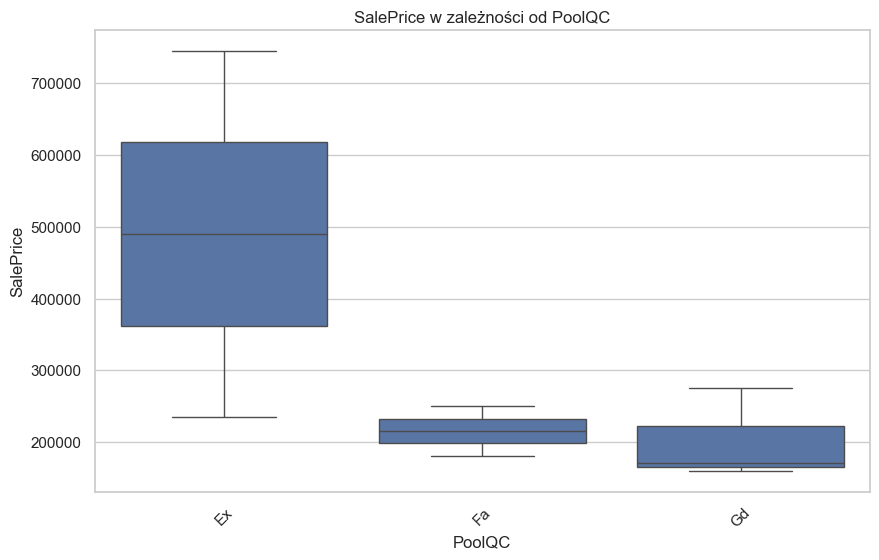

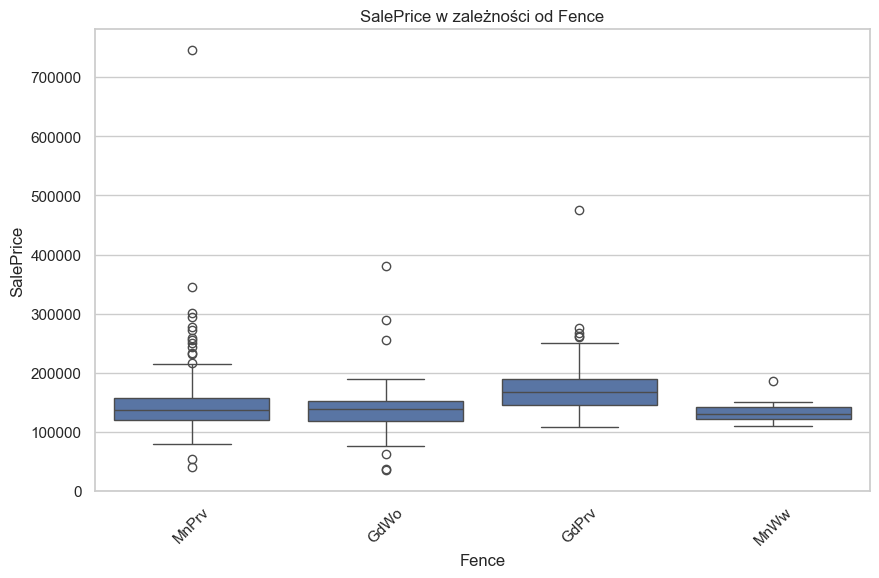

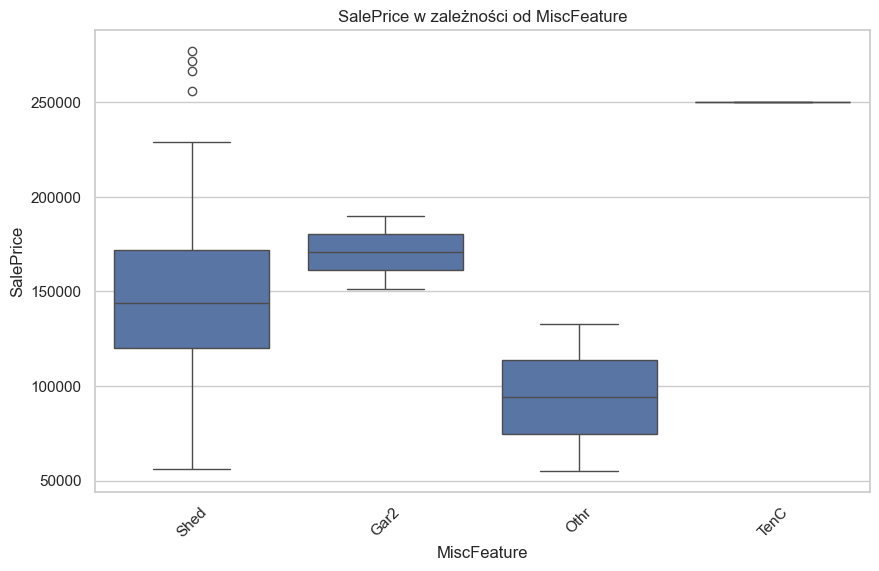

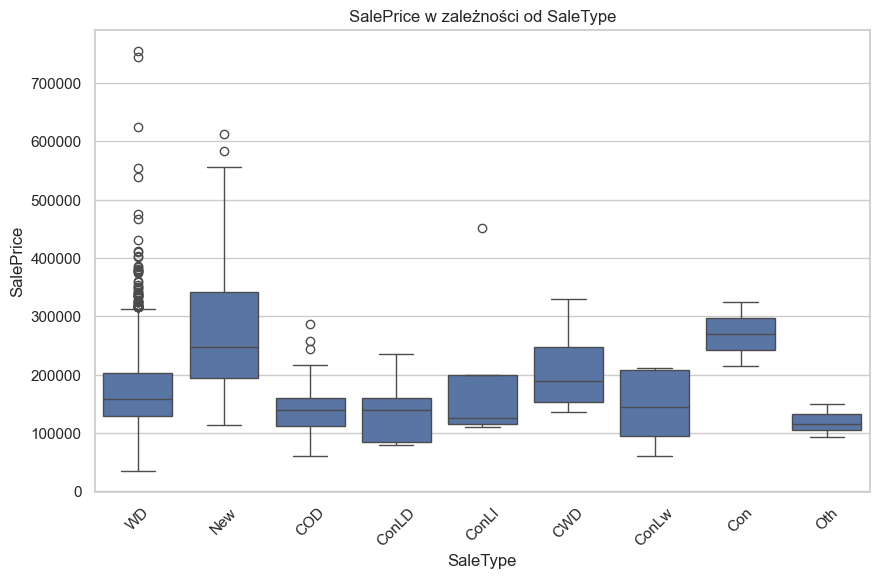

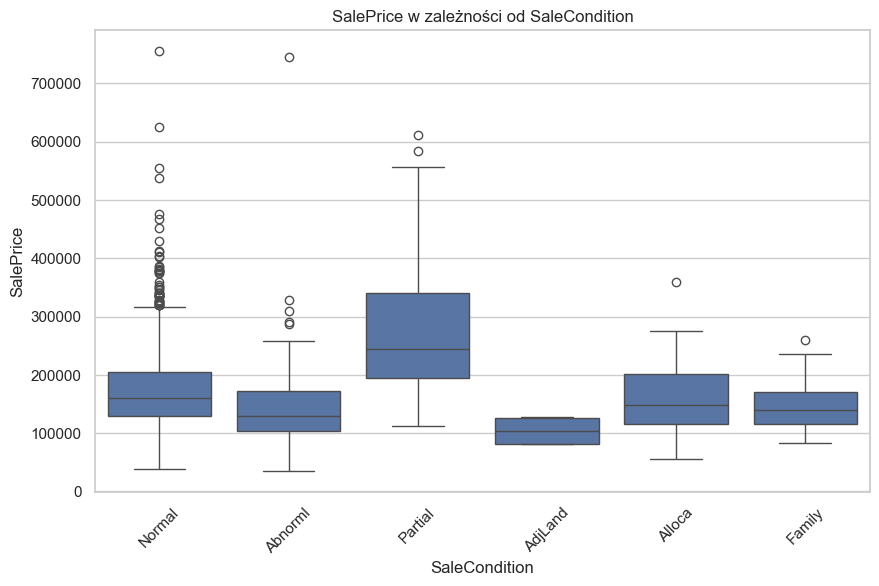

In [22]:
# wykresy pudełkowe dla zmiennych kategorycznych
for col in cat_vars:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=col, y='SalePrice', data=train)
    plt.title(f'SalePrice w zależności od {col}')
    plt.xticks(rotation=45)
    plt.savefig(f'../plots/boxplots/boxplot_{col}.png')
    plt.show()